# Классификация отзывов клиентов сервиса по доставке еды.


---


# Содержание

- [Условия задачи📃](#Условия-задачи:📃)

- [Импорт данных 📥](#Импорт-данных:📥)

- [Предварительный анализ данных:🐈](#Предварительный-анализ-данных:🐈)
  * Общая информацию о DataFrame

  * Сводная статистическая информация о числовых столбцах в DataFrame.
  
  * Расчеты по колонке "Оценка"
  
  * Визуализируем распределение оценок с отывами и без отзывов

  * Считаем уникальные значения в каждой колонке с отзывами
  
  * Проверка периода времени, за который представлены данные
  * Проверяем количество магазинов в базе
  * Проверяем название и количество значений в колонке "Статус"
  


- [Подготовка данных:👨🏻‍🍳](#Подготовка-данных:👨🏻‍🍳)
  * Удаляю и меняю названия колонок
  * Делаю колонку "Настроение" и добавляю два значения "позитивный" и "негативный"


- [Личное расследование:🧐](Личное-расследование:🧐)
  * Расследование о том, кому пренадлежат данные по заказам.
  * Отзывы, указывающие на год
  * Отзывы, указывающие на сервис


- [Векторы TF-IDF в качестве признаков и SVM (Support Vector Machine)🥘](#Векторы-TF-IDF-в-качестве-признаков-и-SVM-(Support-Vector-Machine))

- [Рекомендации:📢](#Рекомендации:📢)





# Условия задачи:📃



#### Задание в рамках трудоустройства на вакансию: Аналитик (отдел заботы о клиентах)

1. Классифицировать фидбэк клиента:

а) задача минимум описать алгоритм подхода решения к этой задаче;

б) задача максимум - разметить (все необязательно).

Классы нужно определить самому на основании текстов отзывов, каким образом будет это сделансо векторизация, ML или что-то еще не принципиально.

Все размечать не нужно, нужно показать уменее, описать алгоритм подхода к решению задачи и часть разметить используя придуманный алгоритм.

Классифицировать фидбэк на хорошо/плохо/нейтрально нет нужды т.к. он итак размечен проставленной оценкой к заказу.

2. Отрисовать данные в любой удобной BI (например DataStudio) из которой можно сделать полезные выводы для сервиса/бизнеса.
Затем нужно набросать макет дашборда, который будет задействовать в т.ч. выполненную разметку.

 Дать ссылку на дашборд



### ДИСКЛЕЙМЕР:
Данная задача была принята работодателем как успешная, проработа структура, проделано несколько подходов для выявления необходимых категорий, сами категории выявлены успешно, дашборд дает общее представление.

Итоги по блоку "Личное расследование":

1. Сервис выявлен не верно, но близко
2. Даты выявлены верно.

### В данном исследовани нет:
* проверки качества модели.
* дополнительных моделей с помощью которых можно было решить данную задачу.
* подробных пояснений того, как я делал выводы с графиков и моделей, все в общих словах.

### Дашборд и сборка диаграмм, которые будут в данном исследовании:
 #### Ссылка на [DASHBOARD]( https://lookerstudio.google.com/reporting/c6cfa58f-9aef-49b0-8a79-d1ba23a89dc5/page/KQwfD?s=h6AIz0JEcQ0)

 Обратите внимание на - [Рекомендации:📢](#Рекомендации:📢)
 в самом конце данного исследования.


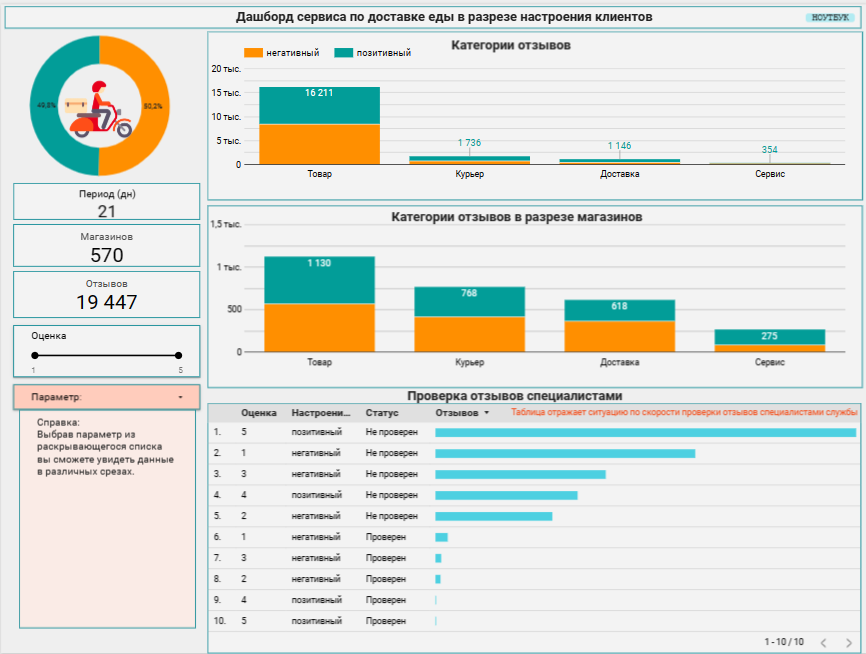



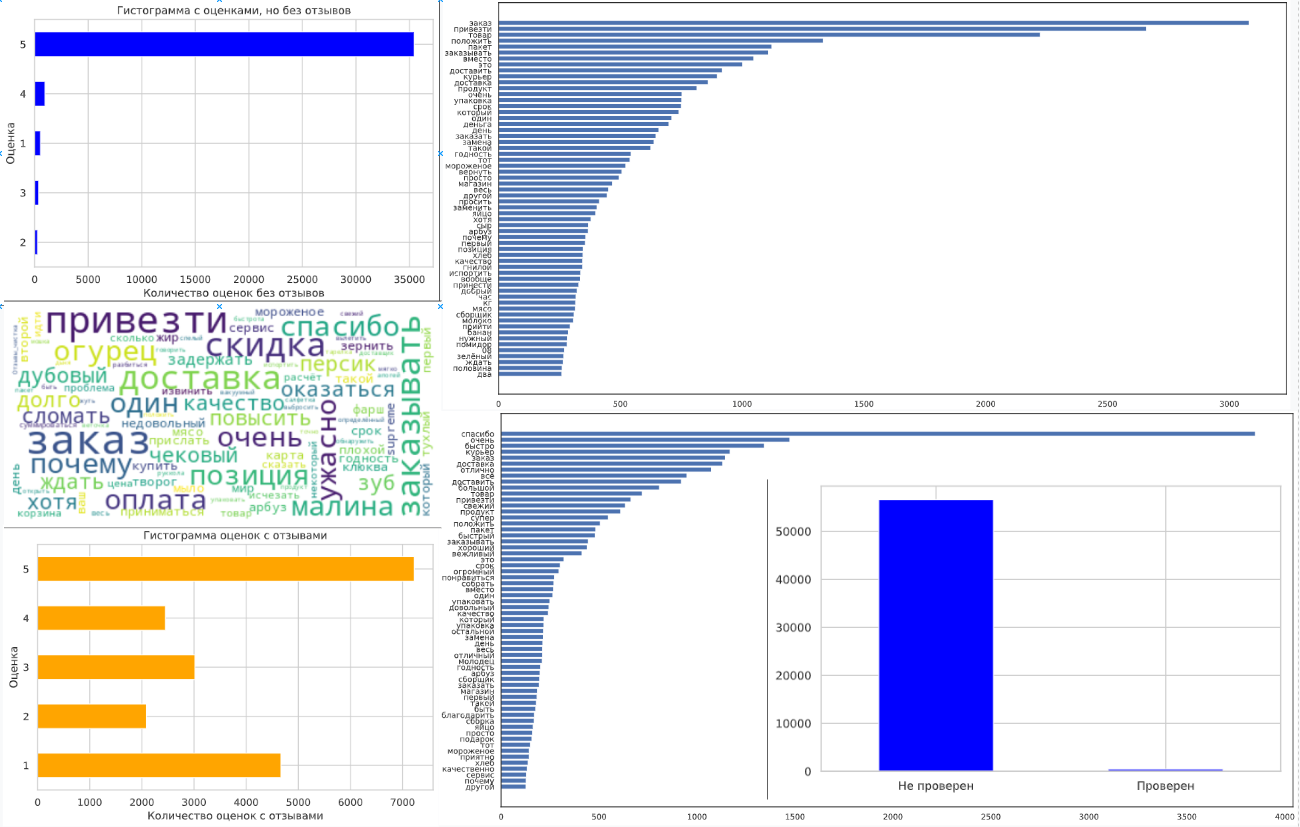

# Импорт данных:📥

In [ ]:
# Импорт стандартной библиотеки
import sqlite3

# Импорт сторонних библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
import scipy
from sklearn.model_selection import train_test_split

import re
import nltk
!pip3 install pymorphy2
!pip install pyenchant
!apt-get install libenchant-dev
!pip install pyspellchecker
!pip install hunspell

import pymorphy2
from nltk.corpus import stopwords
from nltk import FreqDist

# Для обучения моделей
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline

# Импорт специфических локальных библиотек/приложений
from IPython.display import set_matplotlib_formats

# Конфигурация для pandas
pd.plotting.register_matplotlib_converters()
pd.set_option('display.max_colwidth', None)

# Конфигурация для matplotlib
%matplotlib inline
set_matplotlib_formats('svg')
import matplotlib.pyplot as plt
import matplotlib as mpl
# Конфигурация для seaborn
sns.set_style('whitegrid')

# Конфигурация для rcParams
rcParams['figure.figsize'] = 8, 5

# Подсчет количества ядер в процессоре
import multiprocessing
cores = multiprocessing.cpu_count()

# Облако слов
from wordcloud import WordCloud, STOPWORDS


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package libenchant-dev
  Using cached hunspell-0.5.5.tar.gz (34 kB)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for hunspell
  Running setup.py clean for hunspell
Failed to build hunspell
ERROR: Could not build wheels for hunspell, which is required to install pyproject.toml-based projects


<ipython-input-71-65745ef41fac>:42: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


База находится в виде файла SQLite

In [ ]:
# Подключение к базе данных
connection = sqlite3.connect('/content/drive/MyDrive/Colab Notebooks/X5-TestTask/db_sqlite_testovoe')

# Создание курсора
cursor = connection.cursor()


Сводная информация о таблицах и файлах в базе данных.

In [ ]:
# Получение списка таблиц
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()

# Вывод списка таблиц
for table in tables:
    print(table[0])

dostavka


В нашей базе данных только одна таблица "dostavka"

In [ ]:
# Выполнение запроса к базе данных
cursor.execute('SELECT * FROM dostavka')

# Получение результатов
results = cursor.fetchall()

# Создание DataFrame из результатов
df = pd.DataFrame(results, columns=[description[0] for description in cursor.description])

# Вывод первых 10 записей в табличном виде
df.head(10)

,Unnamed: 0,Магазин,Номер заказа,Дата поступления,Статус,Оценка,Текст отзыва,Текст_класс_1,Текст_класс_2,Другое
0,0,store_00,42811R65031404,2011-06-19 00:00:56,Не проверен,5,None,None,None,None
1,1,store_01,143171885R0421,2011-06-19 00:05:42,Не проверен,5,None,None,None,None
2,2,store_02,50488R51918131,2011-06-19 00:08:19,Не проверен,5,None,None,None,None
3,3,store_03,4R556131941173,2011-06-19 00:13:57,Не проверен,3,долго заказ ждал... хотя доставку оплату повысили качество так себе,None,None,None
4,4,store_04,1117R271442037,2011-06-19 00:27:02,Не проверен,3,None,None,None,Без описания
5,5,store_05,3R111814004475,2011-06-19 00:30:14,Не проверен,1,"Персики дубовые , зуб можно сломать !!!!",None,None,None
6,6,store_06,91421174R35122,2011-06-19 00:31:25,Не проверен,5,None,None,None,None
7,7,store_06,711R4433421951,2011-06-19 00:31:52,Не проверен,5,None,None,None,None
8,8,store_07,781129116R1448,2011-06-19 00:48:18,Не проверен,5,None,None,None,None
9,9,store_08,035004185R1135,2011-06-19 00:50:05,Не проверен,1,"Здравствуйте! Ужасно! Я заказывала огурцы, огурцов в доставке не оказалось!! Чеков нет !! Доставку задержали, ужасно недовольна вашим сервисом",None,None,None


In [ ]:
#Закрытие соединения
connection.close()

In [ ]:
df

,Unnamed: 0,Магазин,Номер заказа,Дата поступления,Статус,Оценка,Текст отзыва,Текст_класс_1,Текст_класс_2,Другое
0,0,store_00,42811R65031404,2011-06-19 00:00:56,Не проверен,5,None,None,None,None
1,1,store_01,143171885R0421,2011-06-19 00:05:42,Не проверен,5,None,None,None,None
2,2,store_02,50488R51918131,2011-06-19 00:08:19,Не проверен,5,None,None,None,None
3,3,store_03,4R556131941173,2011-06-19 00:13:57,Не проверен,3,долго заказ ждал... хотя доставку оплату повысили качество так себе,None,None,None
4,4,store_04,1117R271442037,2011-06-19 00:27:02,Не проверен,3,None,None,None,Без описания
...,...,...,...,...,...,...,...,...,...,...
57045,57219,store_00,3219R492601148,2011-06-09 23:28:41,Не проверен,3,Не положили салфетки.\nДыня не спелая,None,None,None
57046,57220,store_0273,0655193509R318,2011-06-09 23:50:35,Не проверен,5,None,None,None,None
57047,57221,store_016,5395R161493216,2011-06-09 23:51:36,Не проверен,5,None,None,None,None
57048,57222,store_0195,121771R1266359,2011-06-09 23:52:17,Не проверен,5,None,None,None,None


# Предварительный анализ данных:🐈



In [ ]:
# Общая информацию о DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57050 entries, 0 to 57049
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        57050 non-null  int64 
 1   Магазин           57050 non-null  object
 2   Номер заказа      57050 non-null  object
 3   Дата поступления  57050 non-null  object
 4   Статус            57050 non-null  object
 5   Оценка            57050 non-null  int64 
 6   Текст отзыва      19447 non-null  object
 7   Текст_класс_1     701 non-null    object
 8   Текст_класс_2     0 non-null      object
 9   Другое            6401 non-null   object
dtypes: int64(2), object(8)
memory usage: 4.4+ MB


🌝 Колонки с 0 по 5 заполнены полностью

🌗 Колонки с 6, 7 и 9 заполнены частично

🌚 В колонке 8 все значения пустые (None)

1️⃣Две колонки числовые, 📃 остальные текстовые


In [ ]:
# Сводная статистическая информация о числовых столбцах в DataFrame.
df.describe()

,Unnamed: 0,Оценка
count,57050.000000,57050.000000
mean,28612.319071,4.331481
std,16518.948813,1.298067
min,0.000000,1.000000
25%,14306.250000,4.000000
50%,28614.500000,5.000000
75%,42914.750000,5.000000
max,57223.000000,5.000000


🥇Система оценок сервиса от 1 до 5.

☝ Средняя оценка 4.33 что является хорошим показателем качества сервиса, но есть куда расти, с помощью анализа настроений мы определим слабые стороны сервиса.

In [ ]:
# Расчеты по колонке "Оценка"

# Подсчет количества пропущенных значений для каждой оценки
missing_counts = df[df['Текст отзыва'].isna()]['Оценка'].value_counts()

# Вывод общего количества значений в столбце 'Оценка'
total_count = df['Оценка'].count()
print(f"Всего значений в столбце 'Оценка': {total_count} шт.")
print(" ")
print("Эти значения в разрезе оценок выглядят следующим образом:")

# Подсчет количества значений с оценками, но без отзывов
missing_reviews_count = missing_counts.sum()
print(f"Из них {missing_reviews_count} значений с оценками, но без отзывов.")

# Вывод результатов
for rating in range(1, 6):
    count = missing_counts.get(rating, 0)
    if rating == 1:
        print(f"{rating} балл - {count} шт.")
    elif rating == 5:
        print(f"{rating} баллов - {count} шт.")
    else:
        print(f"{rating} балла - {count} шт.")

print(" ")

print("Количество оценок с отзывами:")

# Исключить строки с пустыми значениями в столбце 'Текст отзыва'
df_filtered = df.dropna(subset=['Текст отзыва'])

total_orders = df_filtered.shape[0]

print(f"Общее количество заказов с оценками и отзывами: {total_orders} шт.")


# Подсчет количества оценок для каждого балла
rating_counts = df_filtered['Оценка'].value_counts().sort_index()

# Вывод результатов

for rating in range(1, 6):
    count = rating_counts.get(rating, 0)
    if rating == 1:
        print(f"{rating} балл - {count} шт.")
    elif rating == 5:
        print(f"{rating} баллов - {count} шт.")
    else:
        print(f"{rating} балла - {count} шт.")



Всего значений в столбце 'Оценка': 57050 шт.
 
Эти значения в разрезе оценок выглядят следующим образом:
Из них 37603 значений с оценками, но без отзывов.
1 балл - 544 шт.
2 балла - 269 шт.
3 балла - 386 шт.
4 балла - 967 шт.
5 баллов - 35437 шт.
 
Количество оценок с отзывами:
Общее количество заказов с оценками и отзывами: 19447 шт.
1 балл - 4668 шт.
2 балла - 2087 шт.
3 балла - 3016 шт.
4 балла - 2452 шт.
5 баллов - 7224 шт.


💬 Для классификации клиентов по категориям отзыва у нас есть 19447 отзывов в самой объемной колонке по отзывам "Текст отзыва".

В трех колонках содержатся отзывы от клиентов ("Текст отзыва",	"Текст_класс_1", "Другое")

Благодаря выводу значений с использованием цикла ознакомился со всеми отзывами в трех столбцах.
```
# Код для просмотра всех отзывов:
unique_textotzyd = df['Текст отзыва'].unique()

print("Количество уникальных отзывов в колонке :", len(unique_textotzyd))
unique_textotzyd_count = df['Текст отзыва'].value_counts()
print(unique_textotzyd_count)

for value in df['Текст отзыва']:
  print(value)

```

💧 В трех колонках отзывы дублируют друг друга примерно на 90% (судя по визуальному ознакомлению) с помощью втроенного инструмента в Google Colab для создания интерактивной таблицы данных.




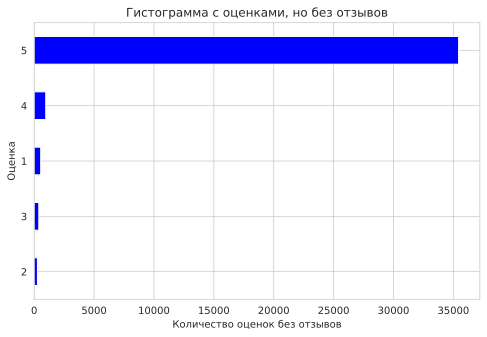

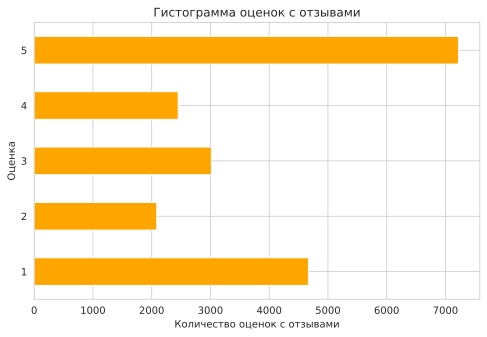

In [ ]:
# Визуализируем распределение оценок с отывами и без отзывов:

# Гистограмма для оценок без отзывов:
missing_counts.plot(kind='barh',color='blue')
plt.xlabel('Количество оценок без отзывов')
plt.ylabel('Оценка')
plt.title('Гистограмма с оценками, но без отзывов')
plt.gca().invert_yaxis() # Изменение направления оси абсцисс

plt.show()

# Гистограмма для оценок с отзывами:
rating_counts.plot(kind='barh', color='orange')
plt.xlabel('Количество оценок с отзывами')
plt.ylabel('Оценка')
plt.title('Гистограмма оценок с отзывами')
plt.show()

😏 судя по гистограммам, мы имеем отзывы практически на все отрицательные отзывы в данном датафрейме

In [ ]:
# Считаем уникальные значения в каждой колонке:
unique_textotzyv = df['Текст отзыва'].unique()
unique_values_1 = df['Текст_класс_1'].unique()
unique_values_2 = df['Текст_класс_2'].unique()
unique_values_3 = df['Другое'].unique()

print("Количество уникальных отзывов в колонке Текст отзыва:", len(unique_textotzyv)-1)
print("Количество уникальных отзывов в колонке Текст_класс_1 :", len(unique_values_1)-1)
print("Количество уникальных отзывов в колонке Текст_класс_2 :", len(unique_values_2)-1)
print("Количество уникальных отзывов в колонке Другое :", len(unique_values_3)-1)
# "-1" для удаления none

Количество уникальных отзывов в колонке Текст отзыва: 18004
Количество уникальных отзывов в колонке Текст_класс_1 : 436
Количество уникальных отзывов в колонке Текст_класс_2 : 0
Количество уникальных отзывов в колонке Другое : 5589


🌶️ Проверил уникальность отзывов в каждой колонке, но на данные показатели ориентироваться не стоит, поскольку отзыв может содержать одинаковые символы, к примеру "Спасибо!", но по факту это считается разными отзывами.

Поэтому удаление дубликатов и объединение столбцов тут использовать нельзя. Буду использовать модели работающие с текстом.

In [ ]:
# Проверка периода времени, за который представлены данные

# Создание нового DataFrame для анализа данных (df_datetime)
df_datetime = df.copy()

# Преобразование столбца с датой в формат datetime
df_datetime['Дата поступления'] = pd.to_datetime(df_datetime['Дата поступления'])

# Нахождение минимальной и максимальной даты
min_date = df_datetime['Дата поступления'].min()
max_date = df_datetime['Дата поступления'].max()

# Расчет разницы в датах
date_diff = max_date - min_date

# Расчет количества лет, месяцев и дней
years = date_diff.days // 365
months = (date_diff.days % 365) // 30
days = (date_diff.days % 365) % 30

# Вывод периода данных
print("Период данных:")
print("От:", min_date)
print("До:", max_date)
print("Данные о доставках заказов за период", years, "лет,", months, "мес.,", days, "дн.")


Период данных:
От: 2011-06-01 00:04:28
До: 2011-06-22 23:54:01
Данные о доставках заказов за период 0 лет, 0 мес., 21 дн.


In [ ]:
# Проверяем количество магазинов в базе:
unique_market = df['Магазин'].unique()

print("Количество магазинов :", len(unique_market)-1)

Количество магазинов : 571


In [ ]:
# Проверяем какие значения находятся в колонке "Статус":
unique_status = df['Статус'].unique()

print("Количество статус :", len(unique_status))
print(unique_status)

Количество статус : 2
['Не проверен' 'Проверен']


In [ ]:
# Проверяем количество по каждому значнию в колонке "Статус":
status_counts = df['Статус'].value_counts()

print("Количество статус 'Проверен':", status_counts['Проверен'])
print("Количество статус 'Не проверен':", status_counts['Не проверен'])


Количество статус 'Проверен': 448
Количество статус 'Не проверен': 56602


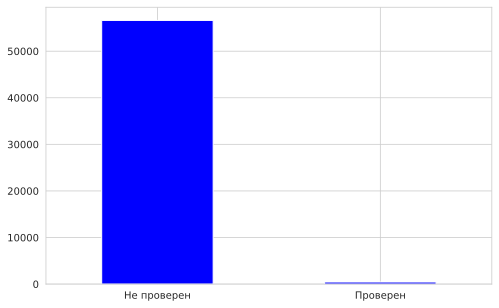

In [ ]:
# посмотрим на распределение по статусу:
df['Статус'].value_counts().plot(kind='bar', color='blue', rot=0)
plt.show()


🗑️ Колонка "Статуст" не будет иметь высокого веса для нашей задачи, хоть ее и можно перевести в бинарный вид. Но мы ее используем для визуализации на дашборде. Данная колонка может дать представление о скорости обработки заявок. Без использования модели можно сделать вывод, что обработка заявок происходит очень медленно, что может негативно сказываться на качестве сервиса и уровне удержания клиентов.



# Подготовка данных: 👨🏻‍🍳


### Готовим датафрейм для обучения модели:

🗑️ Колонку "Текст_класс_2" удаляю, поскольку все значения None

🗑️ Колонку "Текст_класс_1" также удаляю, поскольку в ней около 400 уникальных записей, достаточно было визуально сравнить колонку с другими в Google Colab, при помощи функции конвертирования в интерактивный датафрейм.

  ▶️ Считаю, что в качестве модель не потеряет, а если грузить дополнительными данными, то обучаться модель будет дольше.

🗑️ Колонку "Другое" также удалю в ней около 5000 уникальных записей, при беглом сравнении с другими колонками в Google Colab, похоже что все данные дублируют колонку "Текст отзыва", можно объединить и получить вдвое больше одинаковых данных, но для задачи классификации отзывов нам хватит и одной основной колонки, принципиально нового мы в остальных колонках не найдем. Если бы задача была найти все возможные варианты из имеющихся данных, тогда имеетс смысл объединять все колонки.

🗑️ Удаляем колонки 'Статус', 'Текст_класс_1', 'Дата поступления', 'Магазин'.

🌟 Колонку "Оценка" оставлю.
Используем ее для определения настроения клиента (позитивное и негативное)

    df_model['Оценка'] = df_model['Оценка'].map(lambda x: 0 if x <= 3 else 1)

🌟 Колонку "Номер заказа" оставл, чтобы он был в роли ключа на будущее

🆕 Записываем все в новый датафрейм df_model

In [ ]:
# Удаляем ненужные колонки:
df_model = df.drop(columns=['Статус', 'Текст_класс_1', 'Текст_класс_2', 'Дата поступления', 'Магазин', 'Другое'])

# Переименовываем колонки:
df_model = df_model.rename(columns={
    'Unnamed: 0': 'index',
    'Текст отзыва': 'Отзывы'
})


# Затем мы делаем 'index' индексом DataFrame с помощью метода set_index().
df_model.set_index('index', inplace=True)
df_model.index = df_model.index + 1


In [ ]:
#  Удаляем пустые строки по колонке "Отзывы"
df_model.dropna(subset=['Отзывы'], inplace=True)


In [ ]:
# Удаляю индексную колонку и добавляю новую, в которой счет начинается с единицы:
df_model.reset_index(drop=True, inplace=True)
df_model.index = df_model.index + 1
df_model.rename(columns={'index': 'INDEX'}, inplace=True)

In [ ]:
df_model

,Номер заказа,Оценка,Отзывы
1,4R556131941173,3,долго заказ ждал... хотя доставку оплату повысили качество так себе
2,3R111814004475,1,"Персики дубовые , зуб можно сломать !!!!"
3,035004185R1135,1,"Здравствуйте! Ужасно! Я заказывала огурцы, огурцов в доставке не оказалось!! Чеков нет !! Доставку задержали, ужасно недовольна вашим сервисом"
4,516365424122R1,2,Мясо купили с одним жиром
5,411R8214404085,2,Очень плохой арбуз прислали. Тухлый
...,...,...,...
19443,922R3906011517,2,1) в оплату почему-то не принималась карта Мир supreme! 2) Фарш через три дня уже срок годности
19444,12112973R04104,2,"привезли заказ, из 4 позиций мороженого не привезли ни одного. Зерненный творог заказывали с малиной, привезли один с малиной, второй с клюквой. Мыло так же привезли не то, которое было в заказе. Не первый раз такие проблемы с заказом, уж извините, но сколько можно. Так же цена на некоторые товары идёт со скидкой, а при расчёте в корзине скидка исчезает. Сказали скидка суммируется на весь заказ, но почему тогда только на определённые позиции"
19445,9824R121331164,5,"спасибо, что очень хорошо упаковали тарелки и они не разбились! спасибо доставщику за быстроту"
19446,3219R492601148,3,Не положили салфетки.\nДыня не спелая


In [ ]:
# Делаю колонку "Настроение" и добавляю два значения "позитивный" и "негативный"

df_model['Настроение'] = df_model['Оценка'].apply(lambda x: 'позитивный' if x >= 4 else 'негативный')

df_model



,Номер заказа,Оценка,Отзывы,Настроение
1,4R556131941173,3,долго заказ ждал... хотя доставку оплату повысили качество так себе,негативный
2,3R111814004475,1,"Персики дубовые , зуб можно сломать !!!!",негативный
3,035004185R1135,1,"Здравствуйте! Ужасно! Я заказывала огурцы, огурцов в доставке не оказалось!! Чеков нет !! Доставку задержали, ужасно недовольна вашим сервисом",негативный
4,516365424122R1,2,Мясо купили с одним жиром,негативный
5,411R8214404085,2,Очень плохой арбуз прислали. Тухлый,негативный
...,...,...,...,...
19443,922R3906011517,2,1) в оплату почему-то не принималась карта Мир supreme! 2) Фарш через три дня уже срок годности,негативный
19444,12112973R04104,2,"привезли заказ, из 4 позиций мороженого не привезли ни одного. Зерненный творог заказывали с малиной, привезли один с малиной, второй с клюквой. Мыло так же привезли не то, которое было в заказе. Не первый раз такие проблемы с заказом, уж извините, но сколько можно. Так же цена на некоторые товары идёт со скидкой, а при расчёте в корзине скидка исчезает. Сказали скидка суммируется на весь заказ, но почему тогда только на определённые позиции",негативный
19445,9824R121331164,5,"спасибо, что очень хорошо упаковали тарелки и они не разбились! спасибо доставщику за быстроту",позитивный
19446,3219R492601148,3,Не положили салфетки.\nДыня не спелая,негативный


In [ ]:

df_model.drop('Оценка', inplace=True, axis=1)


In [ ]:
df_model.head()

,Номер заказа,Отзывы,Настроение
1,4R556131941173,долго заказ ждал... хотя доставку оплату повысили качество так себе,негативный
2,3R111814004475,"Персики дубовые , зуб можно сломать !!!!",негативный
3,035004185R1135,"Здравствуйте! Ужасно! Я заказывала огурцы, огурцов в доставке не оказалось!! Чеков нет !! Доставку задержали, ужасно недовольна вашим сервисом",негативный
4,516365424122R1,Мясо купили с одним жиром,негативный
5,411R8214404085,Очень плохой арбуз прислали. Тухлый,негативный


In [ ]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19447 entries, 1 to 19447
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Номер заказа  19447 non-null  object
 1   Отзывы        19447 non-null  object
 2   Настроение    19447 non-null  object
dtypes: object(3)
memory usage: 455.9+ KB


In [ ]:
# Замена знаков препинания на пробелы
df_model["Отзывы_чистка"] = df_model["Отзывы"].str.replace("[^а-яА-ЯёЁa-zA-Z0-9]", " ")

# Переупорядочивание столбцов
df_model = df_model[['Отзывы','Отзывы_чистка','Настроение', 'Номер заказа']]

# Удаление слов длиной менее 3 символов
df_model["Отзывы_чистка"] = df_model["Отзывы_чистка"].apply(lambda row: ' '.join([word for word in row.split() if len(word)>1]))

# Преобразование текста в нижний регистр
df_model["Отзывы_чистка"] = [review.lower() for review in df_model["Отзывы_чистка"]]


<ipython-input-25-71837ff576db>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df_model["Отзывы_чистка"] = df_model["Отзывы"].str.replace("[^а-яА-ЯёЁa-zA-Z0-9]", " ")


In [ ]:
df_model

,Отзывы,Отзывы_чистка,Настроение,Номер заказа
1,долго заказ ждал... хотя доставку оплату повысили качество так себе,долго заказ ждал хотя доставку оплату повысили качество так себе,негативный,4R556131941173
2,"Персики дубовые , зуб можно сломать !!!!",персики дубовые зуб можно сломать,негативный,3R111814004475
3,"Здравствуйте! Ужасно! Я заказывала огурцы, огурцов в доставке не оказалось!! Чеков нет !! Доставку задержали, ужасно недовольна вашим сервисом",здравствуйте ужасно заказывала огурцы огурцов доставке не оказалось чеков нет доставку задержали ужасно недовольна вашим сервисом,негативный,035004185R1135
4,Мясо купили с одним жиром,мясо купили одним жиром,негативный,516365424122R1
5,Очень плохой арбуз прислали. Тухлый,очень плохой арбуз прислали тухлый,негативный,411R8214404085
...,...,...,...,...
19443,1) в оплату почему-то не принималась карта Мир supreme! 2) Фарш через три дня уже срок годности,оплату почему то не принималась карта мир supreme фарш через три дня уже срок годности,негативный,922R3906011517
19444,"привезли заказ, из 4 позиций мороженого не привезли ни одного. Зерненный творог заказывали с малиной, привезли один с малиной, второй с клюквой. Мыло так же привезли не то, которое было в заказе. Не первый раз такие проблемы с заказом, уж извините, но сколько можно. Так же цена на некоторые товары идёт со скидкой, а при расчёте в корзине скидка исчезает. Сказали скидка суммируется на весь заказ, но почему тогда только на определённые позиции",привезли заказ из позиций мороженого не привезли ни одного зерненный творог заказывали малиной привезли один малиной второй клюквой мыло так же привезли не то которое было заказе не первый раз такие проблемы заказом уж извините но сколько можно так же цена на некоторые товары идёт со скидкой при расчёте корзине скидка исчезает сказали скидка суммируется на весь заказ но почему тогда только на определённые позиции,негативный,12112973R04104
19445,"спасибо, что очень хорошо упаковали тарелки и они не разбились! спасибо доставщику за быстроту",спасибо что очень хорошо упаковали тарелки они не разбились спасибо доставщику за быстроту,позитивный,9824R121331164
19446,Не положили салфетки.\nДыня не спелая,не положили салфетки дыня не спелая,негативный,3219R492601148


In [ ]:
# рабочий код



def df_prep(series):
    # Удаление повторяющегося символа \n
    series = series.str.replace('\n', '')

    # Удаление знаков препинания:
    series = series.str.replace('[^\w\s]', ' ', regex=True)

    # Замена всех символов табуляции на пробел:
    series = series.str.replace('\s+', ' ', regex=True)

    # Приведение всего текста к нижнему регистру:
    series = series.str.lower()

    # удаление стоп-слов:
    nltk.download('stopwords')
    stop_words = set(stopwords.words('russian'))
    series = series.apply(
        lambda review: ' '.join([word for word in review.split() if word not in stop_words]))

    # # Проверка правописания:
    # chkr = SpellChecker('ru_RU')

    # def spelling_corrector(sentence):
    #     chkr.set_text(sentence)
    #     for err in chkr:
    #         if len(err.suggest()) > 0:
    #             sug = err.suggest()[0]
    #             err.replace(sug)

    #     return chkr.get_text() if chkr.get_text() else sentence

    # series = series.apply(spelling_corrector)

    # Лемматизация
    morph = pymorphy2.MorphAnalyzer()

    def lemmatizer(sentence):
        words = sentence.split()
        normal_words = [
            morph.parse(word)[0].normal_form
            for word in words
        ]
        return ' '.join(normal_words)

    series = series.apply(lemmatizer)

    return series


In [ ]:
df_model.drop('Отзывы', inplace=True, axis=1)

In [ ]:
%%time
# Рабочий код
# df_model['Отзывы'] = df_prep(df_model['Отзывы'])
df_model['Отзывы_чистка'] = df_prep(df_model['Отзывы_чистка'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


CPU times: user 27.4 s, sys: 4.63 ms, total: 27.4 s
Wall time: 38.6 s


In [ ]:
df_model

,Отзывы_чистка,Настроение,Номер заказа
1,долго заказ ждать хотя доставка оплата повысить качество,негативный,4R556131941173
2,персик дубовый зуб сломать,негативный,3R111814004475
3,здравствуйте ужасно заказывать огурец огурец доставка оказаться чековый доставка задержать ужасно недовольный ваш сервис,негативный,035004185R1135
4,мясо купить один жир,негативный,516365424122R1
5,очень плохой арбуз прислать тухлый,негативный,411R8214404085
...,...,...,...
19443,оплата почему приниматься карта мир supreme фарш день срок годность,негативный,922R3906011517
19444,привезти заказ позиция мороженое привезти один зернить творог заказывать малина привезти малина второй клюква мыло привезти который заказ первый такой проблема заказ извинить сколько цена некоторый товар идти скидка расчёт корзина скидка исчезать сказать скидка суммироваться весь заказ почему определённый позиция,негативный,12112973R04104
19445,спасибо очень упаковать тарелка разбиться спасибо доставщик быстрота,позитивный,9824R121331164
19446,положить салфетка дыня спелый,негативный,3219R492601148



Это все еще стадия подготовки данных для обучения моделей



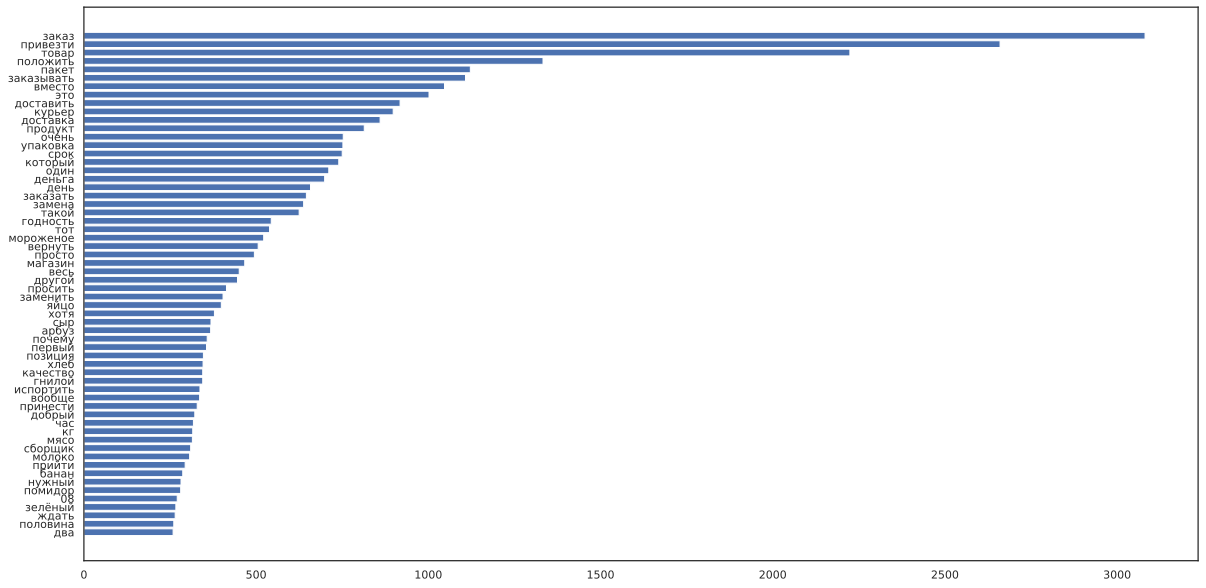

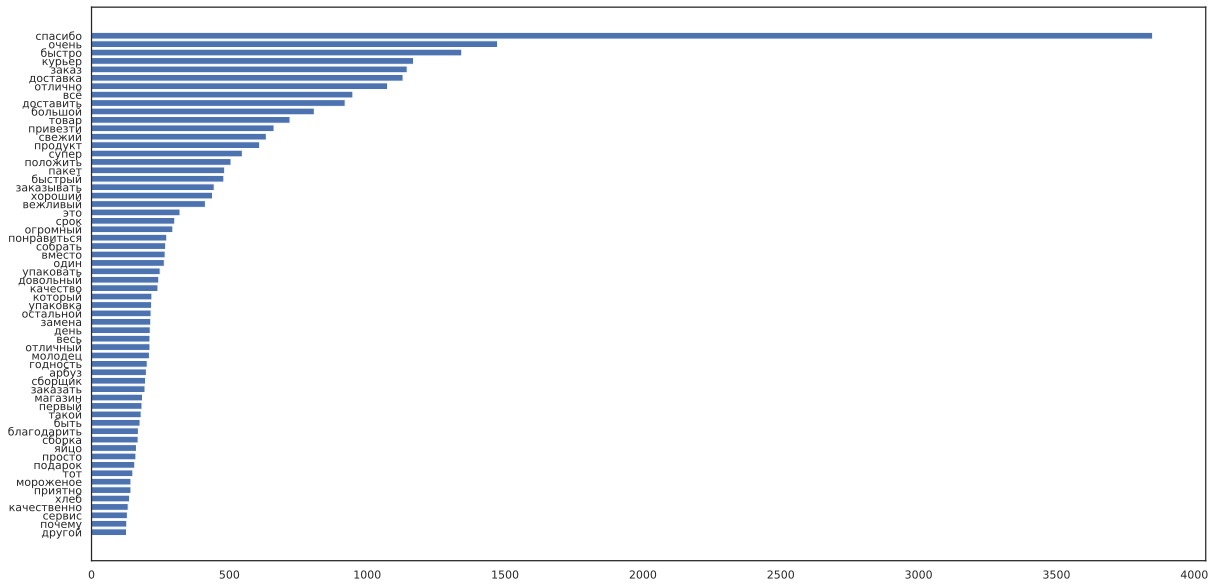

In [ ]:

# Построение гистограммы наиболее часто встречающихся слов из позитивных и негативных отзывов

# Подмножество данных положительных отзывов
all_words_tweets = df_model.loc[df_model['Настроение'] == 'негативный',:]

#Выделение слов из списка и подсчет их частоты
all_words = ' '.join([text for text in all_words_tweets["Отзывы_чистка"]])
all_words = all_words.split()
words_df = FreqDist(all_words)

# Извлечение слов и частот из words_df
words_df = pd.DataFrame({'word':list(words_df.keys()), 'count':list(words_df.values())})
words_df
# Подмножества 60 лучших слов по частоте
words_df = words_df.nlargest(columns="count", n = 60)

words_df.sort_values('count', inplace = True)

#  для позитивных 60 слов

sns.set(style = 'white')
plt.figure(figsize=(20,10))
ax = plt.barh(words_df['word'], width = words_df['count'])
plt.show()


sns.set(style = 'white')
all_words_tweets = df_model.loc[df_model['Настроение'] == 'позитивный',:]
all_words = ' '.join([text for text in all_words_tweets["Отзывы_чистка"]])
all_words = all_words.split()
words_df = FreqDist(all_words)
words_df = pd.DataFrame({'word':list(words_df.keys()), 'count':list(words_df.values())})
words_df
words_df = words_df.nlargest(columns="count", n = 60)
words_df.sort_values('count', inplace = True)
plt.figure(figsize=(20,10))
ax = plt.barh(words_df['word'], width = words_df['count'])
plt.show()

🍭 Датасет готов к обучению

# Личное расследование:🧐


## О чем блок:
####Расследование о том, кому пренадлежат данные по заказам.
  Ранее я определил период, за который предоставлены данные в базе.

    Период данных от: *2011-06-01 00:04:28* до: *2011-06-22 23:54:01*, т.е за 21 день.

Если судить по датам, которые присутствуют в отзывах, могу предположить, что при создании датасета для тестового задания,

    в дате заказов были изменены только месяц с августа на июнь и год с 2021 на 2011.

*В 2011 году? Подобных доставок с таким количеством отывов? Подумал я, поэтому и решил провести свое расследование.*


## Отзывы, указывающие на год:

* Сегодня конец дня 12.08.21 ,а хлеб белый  даже не сегодняшний,а вчерашний.

* Колбаса почти просрочка. До 6.08.2021, а сегодня 2е.08. Вы серьезно ? 500гр колбасы… месяц прошел, нельзя было выбрать с нормальным споком годности?????
одно яйцо было разбито и молоко привезли датированное 31/07, хотя сегодня уже 2/08. В остальном приехали быстро.

* Изготовление: 23.03.2021 - годен до: 20.08.2021

* Положили салат сроком годности до 03.08, сегодня 02.08 - употребить я его планировала в течение нескольких дней - выкинутые деньги на ветер.

* вчера вечером мне привезли заказ. из него 4 йогурта с просрочкой. три с вчерашней датой, 05.08, один с сегодняшней, 06.08. прошу вернуть деньги за йогурты. один,  по не внимательности, сегодня съел. как такое вообще может быть?

* Дарницкий хлеб положили не свежий,аж от 03.08.21!!!!

* Здравствуйте! Впервые заказала продукты в Перекрестке. Очень удивлена, почему сборщик не созвонился по срокам годности?! Хлеб, булочки от 4.08. Крупа манная в дырявой упаковке, это как понимать? Абрикосы очень мягкие (не все, но я бы такие не взяла в магазине...), яблоки битые. Котлеты замороженные в обычном пакете - это чтобы мне размораживать не пришлось? Странно.

* азу из индейки с заканчивающимся сроком годности 08.08.21, не очень понравилось это. можно было так же предложить варианты.

* Филе грудки индейки не свежее. Мясо с налётом, с запахом. Хотя дата стоит употребить до 15.08.21
* Все отлично, если бы не молоко, у которого заканчивается срок 14.08.21г


#### Код для просмотра всех отзывов:

```
unique_textotzyd = df['Текст отзыва'].unique()

print("Количество уникальных отзывов в колонке :", len(unique_textotzyd))
unique_textotzyd_count = df['Текст отзыва'].value_counts()
print(unique_textotzyd_count)

for value in df['Текст отзыва']:
  print(value)
  ```


## Выявление сервиса

  На основе отзывов о сервисе заказа продуктов я пришел к выводу, что это сервис доставки **“Перекресток”**, позже переименованный в **“Vprok.ru”**.

#### Отзывы, указывающие на наименование сервиса:

- **впрок** все же удобнее, но если что-то срочно нужно, может, и буду пользоваться
- как так? делал покупку в techport.ru в качестве вознаграждения предложили промокод на 1300 к vprok.ru. сегодня пришло письмо от **vprok** получите свою скидку, но уже на 500, но промокод остался прежний, а при попытке воспользоваться этим промо пишет, что кода не существует. о подборе: яблоки пришли сморщенные, как-будто месяц провалялись на прилавке **Перекресток**
* Курьер без маски. Кроме того, научите курьеров предоставляться при звонке — это  упрощает работу с клиентами. Делал заказ из **Перекрестка** на адрес мамы и ещё один заказ из другого магазина на свой, в итоге вашему курьеру сказал что меня нет дома и наплёл ерунду про доставку к 11 и мамин заказ необоснованно катался час в машине
* все отлично, сборщики молодцы))) привет от сборщика с другого **Перекрёстка**
* Не прмвезли сыр ,  перезаоеили скми , сказали сейчас пересислчт обратно на кпрту . Го так и не перечислили . Не рекомендую вам **Перекресток** .
* Быстро досьавили. За продукты, которых не было быстро вернули деньги. Спасибо, **Перекресток**!
* Первый раз сделали заказ на сайте Перекрестка. В целом все отлично: быстро, качественно и удобно. Но была и неприятность... Пусть и маленькая, но лучше бы чтоб ее не было.... В заказе было мороженое-сорбет Зеленая Линия манго и груша. Так вот оно пришло просроченное. Дата выпуска была указана на продукте ноябрь 2020 года + пол года = считайте сами на сколько просрочен продукт.
* ну просто ужасно! Ваши сборщики вообще не смотрят на сроки годности?! Мало того, что доставили не те яйца (я заказывала 20 штук Лето, принесли 20 штук **Перекресток** Маркет), так еще и срок годности у них истекает 5 августа! Мы должны 20 яиц съесть за 3 дня?! В предыдущий раз тоже принесли не тот товар. Служба поддержки обещала сообщить сборщикам, чтоб были внимательными. Как вижу, это просто слова
* Отвратительное выполнение заказа! Попросили по-человечески, культурно выбрать бекон и, по видимому, сборщику полевать на пожелания покупателя! Да уж, **Перекресток** уже не тот. Скорее испортите настроение, чем доставите покупателю радость за их же деньги! Ужасно плохо!!!
* Селёдку и говядину принесли протухшие. Втдимо то, что в магазине не продается, можно в доставку впихнуть. Селодка с сильным гнилостным запахом и ржавой слизью. Говядина темного цвета, жир серо-желтый, сам кусок как кисель, расползается, форму не держит, запах тошнотворный. Придется попрощаться с доставкой Перекрестка.
* Сок томатный **Перекресток** - не довезли
* Артишоки - в заказе **Перекресток**, дали Berni
* странно что в Перекрёстке закончились арбузы. Сезон, а арбузов нет
* все свалили в одну кучу и упаковали в скудные 3 пакета! УВАЖАЕМЫЙ **Перекресток**, ЕСЛИ ВАМ ЖАЛКО ПАКЕТОВ ДЛЯ УПАКОВКИ, то ВКЛЮЧИТЕ ИХ В СТОИМОСТЬ !! Оттирать сливки от сахара, муки и масла совсем не весело !!!
* **Перекресток**,что с Вами произошло?! Где сервис,где та доставка до двери за которую вы берете деньги?
* Здравствуйте! Впервые заказала продукты в Перекрестке. Очень удивлена, почему сборщик не созвонился по срокам годности?! Хлеб, булочки от 4.08. Крупа манная в дырявой упаковке, это как понимать? Абрикосы очень мягкие (не все, но я бы такие не взяла в магазине...), яблоки битые. Котлеты замороженные в обычном пакете - это чтобы мне размораживать не пришлось? Странно.








## О сервисе из сети интернет:

[Источник №1](https://globus-ltd.ru/projects/razvitie-onlayngipermarketa-vprokru?ysclid=lnvaqle6xf759838347)
Онлайн-гипермаркет Vprok.ru запущен в 2017 году в Москве. 1 января 2020 года был выделен в самостоятельную бизнес-единицу. Сейчас онлайн-гипермаркет представлен на территории 82 субъектов РФ, в 8 из которых работает в формате курьерской доставки, а еще в 74 — в формате самовывоза.
Начиная с ноября 2019 года команда Globus IT ведет работу над развитием онлайн-гипермаркета Vprok.ru, его складских, курьерских сервисов, серверной и платформенных частей.



[Источник №2](https://merchandising.ru/infobank/cases/kak-perekrestok-onlayn-prevratilsya-v-perekrestok-vprok/?ysclid=lnvan6vuo3691012229) «Перекресток» запустил свой первый онлайн-магазин в 2017 году на базе обычного супермаркета в Коммунарке. Сборщики комплектовали заказы из имеющихся в наличии товаров, а курьеры развозили их по району. Эксперимент удался: спрос на услугу рос, количество заказов увеличивалось, и к концу года ресурсов одной торговой точки стало недостаточно. К магазину пристроили небольшой даркстор и расширили ассортимент.
В 2018 году «Перекресток» стал вторым по величине после «Утконоса» продуктовым интернет-магазином в стране.



# Векторы TF-IDF в качестве признаков и SVM (Support Vector Machine)

Векторы TF-IDF в качестве признаков


TF-IDF - это аббревиатура от Term Frequency Inverse Document Frequency.

Это очень распространенный алгоритм преобразования текста в осмысленное представление чисел, которое используется для подгонки машинного алгоритма прогнозирования.

Term Frequency (tf) - дает нам повторяемость слова в каждом отчете в корпусе. Это соотношение количества раз, когда слово встречается в отчете, к общему количеству слов в этой записи. Она увеличивается по мере увеличения количества событий этого слова в записи.

Inverse Data Frequency (idf) - используется для определения частоты встречаемости редких слов во всех отчетах корпуса. Слова, которые редко встречаются в корпусе, имеют высокий показатель IDF.

Применение функции TfidfVectorizer() к очищенным и разделенным данным review_head путем создания объекта vectorizer с анализатором слов, преобразования и подгонки обучающих данных к A и преобразования тестовых данных к B

Тестирую SVM для классификации данных.

SVM - это алгоритм машинного обучения, который строит гиперплоскость или набор гиперплоскостей в многомерном пространстве для разделения данных разных классов. Он может использоваться для задач классификации и регрессии.


In [ ]:
# Разделение данных на обучающую и проверочную выборки

X_train, X_test, y_train, y_test = train_test_split(df_model['Отзывы_чистка'], df_model['Настроение'], test_size=0.2, random_state=42)

# Отзывы_чистка, Length: X_train =  15557, X_test = 3890 что является в соотношении 75/25

In [ ]:
# Векторизуем текст отзывов с использованием метода TF-IDF. Это позволит представить текст в виде числовых признаков, которые можно использовать для обучения модели.

vectorizer = TfidfVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

In [ ]:
# Создаю и обучая модель SVM с использованием обучающей выборки.

svm_model = SVC()
svm_model.fit(X_train_vectorized, y_train)

SVC()

In [ ]:
# Предсказание категорий на проверочной выборке и оценка производительность модели.

# Предсказание на проверочной выборке
y_pred = svm_model.predict(X_test_vectorized)

# Оценка производительности модели
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

  негативный       0.79      0.95      0.86      1980
  позитивный       0.94      0.73      0.82      1910

    accuracy                           0.84      3890
   macro avg       0.86      0.84      0.84      3890
weighted avg       0.86      0.84      0.84      3890



In [ ]:
# Векторизация всех отзывов
all_reviews_vectorized = vectorizer.transform(df_model['Отзывы_чистка'])

# Предсказание категорий для всех отзывов
predicted_categories = svm_model.predict(all_reviews_vectorized)

# Добавление предсказанных категорий в датафрейм
df_model['Предсказанная_категория'] = predicted_categories

# Вывод уникальных категорий
categories = df_model['Предсказанная_категория'].unique()
categories

array(['негативный', 'позитивный'], dtype=object)

In [ ]:
df_model

,Отзывы_чистка,Настроение,Номер заказа,Предсказанная_категория
1,долго заказ ждать хотя доставка оплата повысить качество,негативный,4R556131941173,негативный
2,персик дубовый зуб сломать,негативный,3R111814004475,негативный
3,здравствуйте ужасно заказывать огурец огурец доставка оказаться чековый доставка задержать ужасно недовольный ваш сервис,негативный,035004185R1135,негативный
4,мясо купить один жир,негативный,516365424122R1,негативный
5,очень плохой арбуз прислать тухлый,негативный,411R8214404085,негативный
...,...,...,...,...
19443,оплата почему приниматься карта мир supreme фарш день срок годность,негативный,922R3906011517,негативный
19444,привезти заказ позиция мороженое привезти один зернить творог заказывать малина привезти малина второй клюква мыло привезти который заказ первый такой проблема заказ извинить сколько цена некоторый товар идти скидка расчёт корзина скидка исчезать сказать скидка суммироваться весь заказ почему определённый позиция,негативный,12112973R04104,негативный
19445,спасибо очень упаковать тарелка разбиться спасибо доставщик быстрота,позитивный,9824R121331164,позитивный
19446,положить салфетка дыня спелый,негативный,3219R492601148,негативный


In [ ]:
X_test_vectorized

<3890x11253 sparse matrix of type '<class 'numpy.float64'>'
	with 31199 stored elements in Compressed Sparse Row format>

## Кластеризация отзывывов:

Данный код выполняет преобразование текстовых отзывов в числовые векторы с использованием TF-IDF и применяет алгоритм K-means для кластеризации данных. Результаты кластеризации сохраняются в DataFrame df_model в виде меток кластеров.

In [ ]:
## ЗАКОММЕНТИРОВАЛ ЧТОБЫ ОБУЧИТЬ LDA

## КЛАСТЕРИЗАЦИЯ


# # Преобразование текста отзывов в числовые векторы с использованием TF-IDF
# vectorizer = TfidfVectorizer()
# X = vectorizer.fit_transform(df_model['Отзывы_чистка'])

# # Применение K-means для кластеризации
# kmeans = KMeans(n_clusters=15)  # Выберите подходящее количество кластеров
# kmeans.fit(X)

# # Добавление меток кластеров в датафрейм
# df_model['cluster'] = kmeans.labels_



In [ ]:
# УБРАЛ ЧТОБЫ ОБУЧИТЬ LDA
# # Для визуализации ключевых слов, наиболее характерных для каждого кластера, вы можете вывести топ-N слов с наибольшими весами TF-IDF для каждого кластера. Это может быть достигнуто путем сортировки векторов TF-IDF по убыванию и выбора первых N элементов.
# order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
# terms = vectorizer.get_feature_names_out()

# for i in range(15):  # 2 - количество кластеров
#     print(f"Cluster {i}:")
#     for ind in order_centroids[i, :15]:  # 15 - количество слов для вывода
#         print(f" {terms[ind]}")
#     print()


### По итогам кластеризации
Мы получили 15 кластеров слов. Из них я постарался определить основные категории отзывов, разделяя их на "позитивные" и "негативные", к примеру отзыв на "Качество товара" может быть как позитивным так и негативным.

### **В итоге я получил 4 категории "Товар", "Курьер", "Доставка", "Сервис"**

Cluster 0:

Негативный: Качество товара

Негативный: Сборка


 товар
 доставить
 привезти
 замена
 заменить
 наличие
 заказ
 предложить
 который
 доставка
 половина
 деньга
 качество
 весь
 отсутствовать

Cluster 1:

Негативный: Качество товара

Позитивный: Доставка

 спасибо
 очень
 всё
 срок
 свежий
 яйцо
 годность
 доставка
 упаковка
 продукт
 понравиться
 гнилой
 банан
 мороженое
 зелёный

Cluster 2:

Негативный: Качество товара

Негативный: Сборка

 привезти
 вместо
 заказ
 заказывать
 тот
 мороженое
 заказать
 хлеб
 банан
 сыр
 который
 вода
 другой
 один
 испортить

Cluster 3:
Негативный: Качество товара


 арбуз
 вкусный
 сладкий
 спасибо
 очень
 привезти
 косточка
 испортить
 внутри
 битый
 гнилой
 спелый
 мягкий
 красный
 оказаться

Cluster 4:

Позитивный: курьер

Позитивный:  Доставка

Позитивный:  СБорка

Позитивный: Качество товара


 курьер
 вежливый
 очень
 спасибо
 быстро
 хороший
 молодец
 доставить
 приятный
 отличный
 маска
 свежий
 большой
 доставка
 огромный

Cluster 5:

Позитивный: Качество товара

Позитивный: Доставка

Позитивный: Курьер

Позитивный: приложение

 отлично
 спасибо
 всё
 благодарить
 быстро
 огромный
 держать
 доставка
 сегодня
 курьер
 собрать
 сервис
 сборщик
 заказывать
 быть

Cluster 6:


Позитивный: Качество товара

Позитивный: Сборка

Позитивный: Курьер

Негативный: Доставка

 доставка
 быстрый
 спасибо
 очень
 продукт
 свежий
 большой
 курьер
 качественный
 хороший
 довольный
 супер
 долгий
 вежливый
 сборка


Cluster 7:
Позитивный: Качество товара

Позитивный: Сборка

Позитивный: Доставка

 спасибо
 огромный
 всё
 заказ
 весь
 свежий
 очень
 хороший
 заказывать
 доставить
 мороженое
 магазин
 просто
 труд
 ваш

Cluster 8:

Негативный : Сборка

Негативный: Качество товара
 пакет
 продукт
 положить
 заказ
 упаковка
 курьер
 мороженое
 один
 привезти
 молоко
 весь
 лежать
 товар
 отдельный
 химия

Cluster 9:

Позитивный: Курьер

Позитивный: Доставка

 супер
 спасибо
 всё
 большой
 быстро
 курьер
 просто
 огромный
 молодец
 доставка
 хороший
 отлично
 быть
 обычно
 очень

Cluster 10:

Негативный : Сборка

Негативный: Качество товара

 положить
 вместо
 заказ
 товар
 тот
 заказывать
 который
 мороженое
 забыть
 другой
 один
 хлеб
 очень
 помидор
 масло

Cluster 11:

Позитивный: Сборка

Позитивный: Качество товара

Позитивный: Доставка

 большой
 спасибо
 отлично
 всё
 очень
 доставка
 курьер
 быстро
 довольный
 свежий
 подарок
 сборщик
 работа
 ваш
 прекрасно

Cluster 12:

Позитивный: Сборка

Позитивный: Качество товара

Позитивный: Доставка

 быстро
 очень
 спасибо
 доставить
 качественно
 собрать
 свежий
 всё
 удобно
 большой
 хороший
 продукт
 отлично
 курьер
 аккуратно

Cluster 13:

Негативный: Сборка

Негативный: Качество товара

 заказывать
 это
 замена
 деньга
 товар
 заказать
 вместо
 вернуть
 заказ
 принести
 заменить
 привезти
 тот
 который
 один

Cluster 14:
Позитивный : Сборка

Негативный: Качество товара

Негативный: Доставка

заказ
 доставить
 курьер
 час
 ждать
 долго
 минута
 позиция
 спасибо
 доставка
 это
 очень
 товар
 собрать
 быстро

In [ ]:
# Дополнительные исследования по выявлению количества категорий отзывов:

# X = vectorizer.fit_transform(df_model['Отзывы_чистка'])
# scores = []
# silhouettes = []

# for k in range(2, 15):  ## Выбор диапазона для k
#     kmeans = KMeans(n_clusters=k, random_state=42).fit(X)
#     score = kmeans.inertia_
#     silhouette = silhouette_score(X, kmeans.labels_)
#     scores.append(score)
#     silhouettes.append(silhouette)

# # Построение графика метода "локтя"

# plt.figure(figsize=(8, 4))
# plt.plot(range(2, 15), scores, marker='s');
# plt.xlabel('$k$')
# plt.ylabel('$J(C_k)$');
# plt.title('Метод "локтя" для определения оптимального $k$');
# plt.grid(True)
# plt.show()



По методу локтя видно что у нас очновное количество кластеров 5-6 штук, которые можно взять в работу или максимум 8

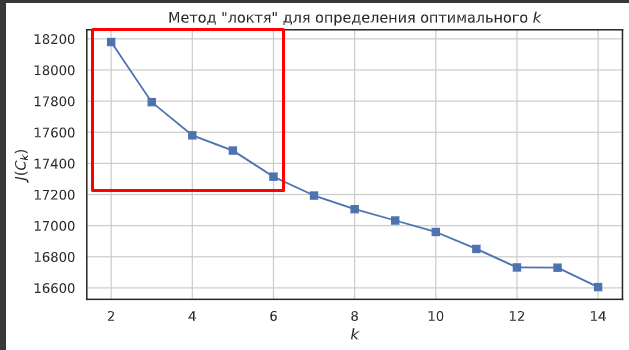

In [ ]:
# from sklearn.metrics import calinski_harabasz_score
# import matplotlib.pyplot as plt

# X = vectorizer.fit_transform(df_model['Отзывы_чистка']).toarray()  # Преобразование в плотную матрицу
# ch_scores = []

# for k in range(2, 15):  # Выбор диапазона для k
#     kmeans = KMeans(n_clusters=k, random_state=42).fit(X)
#     score = calinski_harabasz_score(X, kmeans.labels_)
#     ch_scores.append(score)

# # Построение графика для индекса Калински-Харабаса
# plt.figure(figsize=(8, 4))
# plt.plot(range(2, 15), ch_scores, marker='s');
# plt.xlabel('$k$')
# plt.ylabel('Индекс Калински-Харабаса');
# plt.title('График индекса Калински-Харабаса для определения оптимального $k$');
# plt.grid(True)
# plt.show()

# Код выполнялся 40 минут, завершил, данный метод использовать не буду,

In [ ]:
# УБРАЛ ЧТОБЫ ОБУЧИТЬ LDA, да и график уже есть
# Выявление коэффициента силуэта для определения оптимального $k$

# %%time

# X = vectorizer.fit_transform(df_model['Отзывы_чистка'])  # Ваш датафрейм
# silhouette_scores = []

# for k in range(2, 15):  # Выбор диапазона для k
#     kmeans = KMeans(n_clusters=k, random_state=42).fit(X)
#     score = silhouette_score(X, kmeans.labels_)
#     silhouette_scores.append(score)

# # Построение графика для коэффициента силуэта

# plt.figure(figsize=(8, 4))
# plt.plot(range(2, 15), silhouette_scores, marker='s');
# plt.xlabel('$k$')
# plt.ylabel('Коэффициент силуэта');
# plt.title('График коэффициента силуэта для определения оптимального $k$');
# plt.grid(True)
# plt.show()



График коэффициента силуэта для определения оптимального $k$'
Показывает нам, что оптимальное количество кластеров 3, 7 или 11


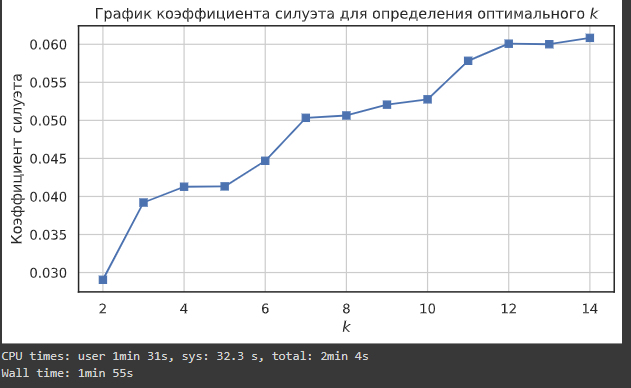

In [ ]:
# Есть несколько библиотек на языке Python, которые позволяют использовать метод LDA (Latent Dirichlet Allocation) для анализа тематической структуры текстовых данных. Одна из популярных библиотек - Gensim. Gensim предоставляет эффективные реализации LDA и других алгоритмов моделирования тем.

# Для использования Gensim для LDA вы можете следовать этим шагам:

# Установите библиотеку Gensim с помощью pip:
# pip install gensim
# Импортируйте необходимые модули:
# from gensim import corpora
# from gensim.models import LdaModel
# Подготовьте данные: Предположим, у вас есть DataFrame с названием df_model, содержащий столбцы "Индекс", "Отзывы_чистка" и "настроение". Перед применением LDA вам необходимо предварительно обработать текстовые данные. Вы можете использовать такие техники, как токенизация, удаление стоп-слов и стемминг. Вот пример токенизации текста с использованием библиотеки NLTK:
# import nltk
# from nltk.tokenize import word_tokenize

# nltk.download('punkt')

# # Токенизация текста
# df_model['tokens'] = df_model['Отзывы_чистка'].apply(word_tokenize)
# Создайте словарь и корпус: Затем вам необходимо создать словарь и корпус на основе токенизированного текста. Словарь сопоставляет каждое слово с уникальным идентификатором, а корпус представляет собой мешок слов для текстовых данных.
# # Создание словаря
# dictionary = corpora.Dictionary(df_model['tokens'])

# # Создание корпуса
# corpus = [dictionary.doc2bow(text) for text in df_model['tokens']]
# Обучите модель LDA: Теперь вы можете обучить модель LDA с использованием корпуса и словаря. Вам необходимо указать количество тем, которые вы хотите извлечь.
# # Обучение модели LDA
# num_topics = 10  # Укажите количество тем
# lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=10)
# Назначьте темы каждому документу: Наконец, вы можете назначить темы каждому документу в вашем DataFrame, используя обученную модель LDA.
# # Назначение тем каждому документу
# df_model['topics'] = df_model['tokens'].apply(lambda x: lda_model.get_document_topics(dictionary.doc2bow(x)))
# Этот код создаст новый столбец "topics" в вашем DataFrame df_model, который будет содержать назначенные темы для каждого документа.

# Не забудьте настроить параметры, такие как количество тем (num_topics) и техники предварительной обработки, чтобы соответствовать вашим конкретным требованиям.

In [ ]:
pip install gensim


In [ ]:
# Необходимые модули:
from gensim import corpora
from gensim.models import LdaModel

In [ ]:
import nltk
from nltk.tokenize import word_tokenize

nltk.download('punkt')

# Токенизация текста
df_model['tokens'] = df_model['Отзывы_чистка'].apply(word_tokenize)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# Создание словаря
dictionary = corpora.Dictionary(df_model['tokens'])

# Создание корпуса
corpus = [dictionary.doc2bow(text) for text in df_model['tokens']]


In [ ]:
# Обучение модели LDA
num_topics = 10  # количество тем
lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=10)


In [ ]:
# Назначение тем каждому документу
df_model['topics'] = df_model['tokens'].apply(lambda x: lda_model.get_document_topics(dictionary.doc2bow(x)))


In [ ]:
df_model

,Отзывы_чистка,Настроение,Номер заказа,Предсказанная_категория,tokens,topics
1,долго заказ ждать хотя доставка оплата повысить качество,негативный,4R556131941173,негативный,"[долго, заказ, ждать, хотя, доставка, оплата, повысить, качество]","[(0, 0.011126843), (1, 0.12792623), (2, 0.01112425), (3, 0.011125149), (4, 0.6712367), (5, 0.122952536), (6, 0.011125698), (7, 0.011129738), (8, 0.011126048), (9, 0.011126807)]"
2,персик дубовый зуб сломать,негативный,3R111814004475,негативный,"[персик, дубовый, зуб, сломать]","[(0, 0.020005343), (1, 0.02000576), (2, 0.4199791), (3, 0.020005343), (4, 0.020005343), (5, 0.41997015), (6, 0.020005343), (7, 0.020005343), (8, 0.020012897), (9, 0.020005343)]"
3,здравствуйте ужасно заказывать огурец огурец доставка оказаться чековый доставка задержать ужасно недовольный ваш сервис,негативный,035004185R1135,негативный,"[здравствуйте, ужасно, заказывать, огурец, огурец, доставка, оказаться, чековый, доставка, задержать, ужасно, недовольный, ваш, сервис]","[(2, 0.28023314), (4, 0.43084267), (7, 0.23895907)]"
4,мясо купить один жир,негативный,516365424122R1,негативный,"[мясо, купить, один, жир]","[(0, 0.020000687), (1, 0.020007227), (2, 0.020000707), (3, 0.020006105), (4, 0.020001259), (5, 0.020000799), (6, 0.020000687), (7, 0.020000687), (8, 0.020002132), (9, 0.81997967)]"
5,очень плохой арбуз прислать тухлый,негативный,411R8214404085,негативный,"[очень, плохой, арбуз, прислать, тухлый]","[(0, 0.12651505), (1, 0.016668169), (2, 0.21235473), (3, 0.016670663), (4, 0.0166673), (5, 0.18334268), (6, 0.016669579), (7, 0.016669141), (8, 0.37777543), (9, 0.016667224)]"
...,...,...,...,...,...,...
19443,оплата почему приниматься карта мир supreme фарш день срок годность,негативный,922R3906011517,негативный,"[оплата, почему, приниматься, карта, мир, supreme, фарш, день, срок, годность]","[(0, 0.011023504), (1, 0.4677404), (2, 0.22839896), (3, 0.01102403), (4, 0.0110247545), (5, 0.011023517), (6, 0.011023508), (7, 0.011026244), (8, 0.011023528), (9, 0.22669151)]"
19444,привезти заказ позиция мороженое привезти один зернить творог заказывать малина привезти малина второй клюква мыло привезти который заказ первый такой проблема заказ извинить сколько цена некоторый товар идти скидка расчёт корзина скидка исчезать сказать скидка суммироваться весь заказ почему определённый позиция,негативный,12112973R04104,негативный,"[привезти, заказ, позиция, мороженое, привезти, один, зернить, творог, заказывать, малина, привезти, малина, второй, клюква, мыло, привезти, который, заказ, первый, такой, проблема, заказ, извинить, сколько, цена, некоторый, товар, идти, скидка, расчёт, корзина, скидка, исчезать, сказать, скидка, суммироваться, весь, заказ, почему, определённый, позиция]","[(3, 0.18234049), (4, 0.20743152), (5, 0.032787874), (9, 0.5624926)]"
19445,спасибо очень упаковать тарелка разбиться спасибо доставщик быстрота,позитивный,9824R121331164,позитивный,"[спасибо, очень, упаковать, тарелка, разбиться, спасибо, доставщик, быстрота]","[(0, 0.38957825), (1, 0.14003213), (2, 0.011126355), (3, 0.011126355), (4, 0.011126355), (5, 0.122338645), (6, 0.17099589), (7, 0.011126571), (8, 0.0111264605), (9, 0.121422976)]"
19446,положить салфетка дыня спелый,негативный,3219R492601148,негативный,"[положить, салфетка, дыня, спелый]","[(0, 0.020000923), (1, 0.02000226), (2, 0.020002274), (3, 0.38354847), (4, 0.020000923), (5, 0.020000933), (6, 0.020000923), (7, 0.020001873), (8, 0.020000923), (9, 0.45644054)]"




LDA - это вероятностная модель, используемая для анализа тематической структуры в коллекции текстовых данных.

LDA позволяет выявить скрытые темы в коллекции документов и определить, какие слова чаще всего связаны с каждой темой. Она предполагает, что каждый документ в коллекции представлен как смесь различных тем, а каждая тема представлена как распределение вероятностей по словам.

В данном коде модель LDA хранится в переменной lda_model. Она вероятно была обучена на некоторой коллекции текстовых данных и содержит информацию о темах и их связанных словах.

Функция get_topic_label используется для извлечения ключевых слов для заданной темы из модели LDA. Она вызывается для каждой темы в столбце 'topics' в датафрейме df_model, и результат сохраняется в новом столбце 'topic_labels'.

Если у вас есть дополнительные вопросы или нужна дополнительная информация, пожалуйста, уточните.

### Модель LDA (Latent Dirichlet Allocation).

LDA - это вероятностная модель, используемая для анализа тематической структуры в коллекции текстовых данных.

С помощью LDA выявляем скрытые темы в колонке с отзывами в и определяем, какие слова чаще всего связаны с каждой темой.

In [ ]:
# Модель LDA хранится в lda_model, а столбец topics - в DataFrame с именем df

def get_topic_label(ldamodel, topic):
    wp = ldamodel.show_topic(topic)
    topic_keywords = ", ".join([word for word, prop in wp])
    return topic_keywords

df_model['topic_labels'] = df_model['topics'].apply(lambda x: get_topic_label(lda_model, x[0][0]))

# Таким образом, код выполняет извлечение ключевых слов для каждой темы из модели LDA и сохраняет их в новом столбце 'topic_labels' в датафрейме df_model.

In [ ]:
df_model

,Отзывы_чистка,Настроение,Номер заказа,Предсказанная_категория,tokens,topics,topic_labels
1,долго заказ ждать хотя доставка оплата повысить качество,негативный,4R556131941173,негативный,"[долго, заказ, ждать, хотя, доставка, оплата, повысить, качество]","[(0, 0.011126843), (1, 0.12792623), (2, 0.01112425), (3, 0.011125149), (4, 0.6712367), (5, 0.122952536), (6, 0.011125698), (7, 0.011129738), (8, 0.011126048), (9, 0.011126807)]","очень, быстро, доставить, курьер, спасибо, заказ, свежий, вежливый, продукт, товар"
2,персик дубовый зуб сломать,негативный,3R111814004475,негативный,"[персик, дубовый, зуб, сломать]","[(0, 0.020005343), (1, 0.02000576), (2, 0.4199791), (3, 0.020005343), (4, 0.020005343), (5, 0.41997015), (6, 0.020005343), (7, 0.020005343), (8, 0.020012897), (9, 0.020005343)]","очень, быстро, доставить, курьер, спасибо, заказ, свежий, вежливый, продукт, товар"
3,здравствуйте ужасно заказывать огурец огурец доставка оказаться чековый доставка задержать ужасно недовольный ваш сервис,негативный,035004185R1135,негативный,"[здравствуйте, ужасно, заказывать, огурец, огурец, доставка, оказаться, чековый, доставка, задержать, ужасно, недовольный, ваш, сервис]","[(2, 0.28023314), (4, 0.43084267), (7, 0.23895907)]","деньга, вернуть, привезти, огурец, рыба, кг, просить, положить, тухлый, вместо"
4,мясо купить один жир,негативный,516365424122R1,негативный,"[мясо, купить, один, жир]","[(0, 0.020000687), (1, 0.020007227), (2, 0.020000707), (3, 0.020006105), (4, 0.020001259), (5, 0.020000799), (6, 0.020000687), (7, 0.020000687), (8, 0.020002132), (9, 0.81997967)]","очень, быстро, доставить, курьер, спасибо, заказ, свежий, вежливый, продукт, товар"
5,очень плохой арбуз прислать тухлый,негативный,411R8214404085,негативный,"[очень, плохой, арбуз, прислать, тухлый]","[(0, 0.12651505), (1, 0.016668169), (2, 0.21235473), (3, 0.016670663), (4, 0.0166673), (5, 0.18334268), (6, 0.016669579), (7, 0.016669141), (8, 0.37777543), (9, 0.016667224)]","очень, быстро, доставить, курьер, спасибо, заказ, свежий, вежливый, продукт, товар"
...,...,...,...,...,...,...,...
19443,оплата почему приниматься карта мир supreme фарш день срок годность,негативный,922R3906011517,негативный,"[оплата, почему, приниматься, карта, мир, supreme, фарш, день, срок, годность]","[(0, 0.011023504), (1, 0.4677404), (2, 0.22839896), (3, 0.01102403), (4, 0.0110247545), (5, 0.011023517), (6, 0.011023508), (7, 0.011026244), (8, 0.011023528), (9, 0.22669151)]","очень, быстро, доставить, курьер, спасибо, заказ, свежий, вежливый, продукт, товар"
19444,привезти заказ позиция мороженое привезти один зернить творог заказывать малина привезти малина второй клюква мыло привезти который заказ первый такой проблема заказ извинить сколько цена некоторый товар идти скидка расчёт корзина скидка исчезать сказать скидка суммироваться весь заказ почему определённый позиция,негативный,12112973R04104,негативный,"[привезти, заказ, позиция, мороженое, привезти, один, зернить, творог, заказывать, малина, привезти, малина, второй, клюква, мыло, привезти, который, заказ, первый, такой, проблема, заказ, извинить, сколько, цена, некоторый, товар, идти, скидка, расчёт, корзина, скидка, исчезать, сказать, скидка, суммироваться, весь, заказ, почему, определённый, позиция]","[(3, 0.18234049), (4, 0.20743152), (5, 0.032787874), (9, 0.5624926)]","привезти, товар, вместо, положить, замена, заказывать, заказ, тот, заменить, заказать"
19445,спасибо очень упаковать тарелка разбиться спасибо доставщик быстрота,позитивный,9824R121331164,позитивный,"[спасибо, очень, упаковать, тарелка, разбиться, спасибо, доставщик, быстрота]","[(0, 0.38957825), (1, 0.14003213), (2, 0.011126355), (3, 0.011126355), (4, 0.011126355), (5, 0.122338645), (6, 0.17099589), (7, 0.011126571), (8, 0.0111264605), (9, 0.121422976)]","очень, быстро, доставить, курьер, спасибо, заказ, свежий, вежливый, продукт, товар"
19446,положить салфетка дыня спелый,негативный,3219R492601148,негативный,"[положить, салфетка, дыня, спелый]","[(0, 0.020000923),

### Повторное использоваине SVM (Support Vector Machine)

In [ ]:

# Распределяем наши 4 категории

# Обучающая выборка
train_data = [
    ("Отличный товар", "Товар"),
    ("Плохой курьер", "Курьер"),
    ("Долгая доставка", "Доставка"),
    ("Ужасный сервис", "Сервис"),
    ("Проблемы с сборкой", "Сборка")
]

# Создание модели SVM
svm_model = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("svm", SVC(kernel="linear"))
])

# Обучение модели
X_train = [data[0] for data in train_data]
y_train = [data[1] for data in train_data]
svm_model.fit(X_train, y_train)

# Применение модели к датафрейму df_model
X_test = df_model["tokens"].apply(lambda x: ' '.join(x))
predicted_categories = svm_model.predict(X_test)

# Запись предсказанных категорий в отдельную колонку "Категория"
df_model["Категория"] = predicted_categories



Я добавил еще одну, с надеждой на то, что модель сможет её выявить это "Сборка" жалобы на то что положили не тот товар.

Но модель не нашла подобных отзывов и тут стоит попробовать провести коррекцию параметров.

In [ ]:
df_model

,Отзывы_чистка,Настроение,Номер заказа,Предсказанная_категория,tokens,topics,topic_labels,Категория
1,долго заказ ждать хотя доставка оплата повысить качество,негативный,4R556131941173,негативный,"[долго, заказ, ждать, хотя, доставка, оплата, повысить, качество]","[(0, 0.011126843), (1, 0.12792623), (2, 0.01112425), (3, 0.011125149), (4, 0.6712367), (5, 0.122952536), (6, 0.011125698), (7, 0.011129738), (8, 0.011126048), (9, 0.011126807)]","очень, быстро, доставить, курьер, спасибо, заказ, свежий, вежливый, продукт, товар",Доставка
2,персик дубовый зуб сломать,негативный,3R111814004475,негативный,"[персик, дубовый, зуб, сломать]","[(0, 0.020005343), (1, 0.02000576), (2, 0.4199791), (3, 0.020005343), (4, 0.020005343), (5, 0.41997015), (6, 0.020005343), (7, 0.020005343), (8, 0.020012897), (9, 0.020005343)]","очень, быстро, доставить, курьер, спасибо, заказ, свежий, вежливый, продукт, товар",Товар
3,здравствуйте ужасно заказывать огурец огурец доставка оказаться чековый доставка задержать ужасно недовольный ваш сервис,негативный,035004185R1135,негативный,"[здравствуйте, ужасно, заказывать, огурец, огурец, доставка, оказаться, чековый, доставка, задержать, ужасно, недовольный, ваш, сервис]","[(2, 0.28023314), (4, 0.43084267), (7, 0.23895907)]","деньга, вернуть, привезти, огурец, рыба, кг, просить, положить, тухлый, вместо",Доставка
4,мясо купить один жир,негативный,516365424122R1,негативный,"[мясо, купить, один, жир]","[(0, 0.020000687), (1, 0.020007227), (2, 0.020000707), (3, 0.020006105), (4, 0.020001259), (5, 0.020000799), (6, 0.020000687), (7, 0.020000687), (8, 0.020002132), (9, 0.81997967)]","очень, быстро, доставить, курьер, спасибо, заказ, свежий, вежливый, продукт, товар",Товар
5,очень плохой арбуз прислать тухлый,негативный,411R8214404085,негативный,"[очень, плохой, арбуз, прислать, тухлый]","[(0, 0.12651505), (1, 0.016668169), (2, 0.21235473), (3, 0.016670663), (4, 0.0166673), (5, 0.18334268), (6, 0.016669579), (7, 0.016669141), (8, 0.37777543), (9, 0.016667224)]","очень, быстро, доставить, курьер, спасибо, заказ, свежий, вежливый, продукт, товар",Курьер
...,...,...,...,...,...,...,...,...
19443,оплата почему приниматься карта мир supreme фарш день срок годность,негативный,922R3906011517,негативный,"[оплата, почему, приниматься, карта, мир, supreme, фарш, день, срок, годность]","[(0, 0.011023504), (1, 0.4677404), (2, 0.22839896), (3, 0.01102403), (4, 0.0110247545), (5, 0.011023517), (6, 0.011023508), (7, 0.011026244), (8, 0.011023528), (9, 0.22669151)]","очень, быстро, доставить, курьер, спасибо, заказ, свежий, вежливый, продукт, товар",Товар
19444,привезти заказ позиция мороженое привезти один зернить творог заказывать малина привезти малина второй клюква мыло привезти который заказ первый такой проблема заказ извинить сколько цена некоторый товар идти скидка расчёт корзина скидка исчезать сказать скидка суммироваться весь заказ почему определённый позиция,негативный,12112973R04104,негативный,"[привезти, заказ, позиция, мороженое, привезти, один, зернить, творог, заказывать, малина, привезти, малина, второй, клюква, мыло, привезти, который, заказ, первый, такой, проблема, заказ, извинить, сколько, цена, некоторый, товар, идти, скидка, расчёт, корзина, скидка, исчезать, сказать, скидка, суммироваться, весь, заказ, почему, определённый, позиция]","[(3, 0.18234049), (4, 0.20743152), (5, 0.032787874), (9, 0.5624926)]","привезти, товар, вместо, положить, замена, заказывать, заказ, тот, заменить, заказать",Товар
19445,спасибо очень упаковать тарелка разбиться спасибо доставщик быстрота,позитивный,9824R121331164,позитивный,"[спасибо, очень, упаковать, тарелка, разбиться, спасибо, доставщик, быстрота]","[(0, 0.38957825), (1, 0.14003213), (2, 0.011126355), (3, 0.011126355), (4, 0.011126355), (5, 0.122338645), (6, 0.17099589), (7, 0.011126571), (8, 0.0111264605), (9, 0.121422976)]","очень, быстро, доставить, курьер, спасибо, заказ, свежий, вежливый, продукт, товар",Товар
19446,положить салфетка дыня спелый,негативный,3219R49260114

### Выгрузка датафрейма для визуализации на дашборде:

1. Будем объединять наш исходный датафрейм и полученный в ходе обучения по ключу "Номер заказа"

2. Потом проведем чистку от пустых строк и уберем ненужные колонки.

3. В итоге выгрузим в CSV и Excel файлы

4. Будем использовать Инструмент по визуализации lookerstudio.google.com подтянув базу из диска Google как Google Table


In [ ]:
# Оставить только нужные колонки
new_df = df_model[["Отзывы_чистка", "Настроение", "Категория", "Номер заказа"]]

# Переименовать колонку "Отзывы_чистка" в "Отзывы клиентов"
new_df = new_df.rename(columns={"Отзывы_чистка": "Отзывы клиентов"})

# Сохранить новый датафрейм в файл формата CSV
new_df.to_csv("new_dataframe.csv", index=False)


In [ ]:
new_df

,Отзывы клиентов,Настроение,Категория,Номер заказа
1,долго заказ ждать хотя доставка оплата повысить качество,негативный,Доставка,4R556131941173
2,персик дубовый зуб сломать,негативный,Товар,3R111814004475
3,здравствуйте ужасно заказывать огурец огурец доставка оказаться чековый доставка задержать ужасно недовольный ваш сервис,негативный,Доставка,035004185R1135
4,мясо купить один жир,негативный,Товар,516365424122R1
5,очень плохой арбуз прислать тухлый,негативный,Курьер,411R8214404085
...,...,...,...,...
19443,оплата почему приниматься карта мир supreme фарш день срок годность,негативный,Товар,922R3906011517
19444,привезти заказ позиция мороженое привезти один зернить творог заказывать малина привезти малина второй клюква мыло привезти который заказ первый такой проблема заказ извинить сколько цена некоторый товар идти скидка расчёт корзина скидка исчезать сказать скидка суммироваться весь заказ почему определённый позиция,негативный,Товар,12112973R04104
19445,спасибо очень упаковать тарелка разбиться спасибо доставщик быстрота,позитивный,Товар,9824R121331164
19446,положить салфетка дыня спелый,негативный,Товар,3219R492601148


In [ ]:
# Импорт стандартной библиотеки
import sqlite3
# Подключение к базе данных
connection = sqlite3.connect('/content/drive/MyDrive/Colab Notebooks/X5-TestTask/db_sqlite_testovoe')
# Создание курсора
cursor = connection.cursor()
# Выполнение запроса к базе данных
cursor.execute('SELECT * FROM dostavka')
# Получение результатов
results = cursor.fetchall()
# Создание DataFrame из результатов
df_full = pd.DataFrame(results, columns=[description[0] for description in cursor.description])
# Вывод первых 10 записей в табличном виде
df_full.head(10)

,Unnamed: 0,Магазин,Номер заказа,Дата поступления,Статус,Оценка,Текст отзыва,Текст_класс_1,Текст_класс_2,Другое
0,0,store_00,42811R65031404,2011-06-19 00:00:56,Не проверен,5,None,None,None,None
1,1,store_01,143171885R0421,2011-06-19 00:05:42,Не проверен,5,None,None,None,None
2,2,store_02,50488R51918131,2011-06-19 00:08:19,Не проверен,5,None,None,None,None
3,3,store_03,4R556131941173,2011-06-19 00:13:57,Не проверен,3,долго заказ ждал... хотя доставку оплату повысили качество так себе,None,None,None
4,4,store_04,1117R271442037,2011-06-19 00:27:02,Не проверен,3,None,None,None,Без описания
5,5,store_05,3R111814004475,2011-06-19 00:30:14,Не проверен,1,"Персики дубовые , зуб можно сломать !!!!",None,None,None
6,6,store_06,91421174R35122,2011-06-19 00:31:25,Не проверен,5,None,None,None,None
7,7,store_06,711R4433421951,2011-06-19 00:31:52,Не проверен,5,None,None,None,None
8,8,store_07,781129116R1448,2011-06-19 00:48:18,Не проверен,5,None,None,None,None
9,9,store_08,035004185R1135,2011-06-19 00:50:05,Не проверен,1,"Здравствуйте! Ужасно! Я заказывала огурцы, огурцов в доставке не оказалось!! Чеков нет !! Доставку задержали, ужасно недовольна вашим сервисом",None,None,None


In [ ]:
#Закрытие соединения
connection.close()

In [ ]:
# Объединение датафреймов по колонке "Номер заказа"
merged_df = pd.merge(df_full, new_df, on="Номер заказа", how="left")

# Заполнение отсутствующих данных пустыми строками
merged_df = merged_df.fillna("")

# Вывод объединенного датафрейма
merged_df


,Unnamed: 0,Магазин,Номер заказа,Дата поступления,Статус,Оценка,Текст отзыва,Текст_класс_1,Текст_класс_2,Другое,Отзывы клиентов,Настроение,Категория
0,0,store_00,42811R65031404,2011-06-19 00:00:56,Не проверен,5,,,,,,,
1,1,store_01,143171885R0421,2011-06-19 00:05:42,Не проверен,5,,,,,,,
2,2,store_02,50488R51918131,2011-06-19 00:08:19,Не проверен,5,,,,,,,
3,3,store_03,4R556131941173,2011-06-19 00:13:57,Не проверен,3,долго заказ ждал... хотя доставку оплату повысили качество так себе,,,,долго заказ ждать хотя доставка оплата повысить качество,негативный,Доставка
4,4,store_04,1117R271442037,2011-06-19 00:27:02,Не проверен,3,,,,Без описания,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...
57045,57219,store_00,3219R492601148,2011-06-09 23:28:41,Не проверен,3,Не положили салфетки.\nДыня не спелая,,,,положить салфетка дыня спелый,негативный,Товар
57046,57220,store_0273,0655193509R318,2011-06-09 23:50:35,Не проверен,5,,,,,,,
57047,57221,store_016,5395R161493216,2011-06-09 23:51:36,Не проверен,5,,,,,,,
57048,57222,store_0195,121771R1266359,2011-06-09 23:52:17,Не проверен,5,,,,,,,


In [ ]:
merged_df

,Unnamed: 0,Магазин,Номер заказа,Дата поступления,Статус,Оценка,Текст отзыва,Текст_класс_1,Текст_класс_2,Другое,Отзывы клиентов,Настроение,Категория
0,0,store_00,42811R65031404,2011-06-19 00:00:56,Не проверен,5,,,,,,,
1,1,store_01,143171885R0421,2011-06-19 00:05:42,Не проверен,5,,,,,,,
2,2,store_02,50488R51918131,2011-06-19 00:08:19,Не проверен,5,,,,,,,
3,3,store_03,4R556131941173,2011-06-19 00:13:57,Не проверен,3,долго заказ ждал... хотя доставку оплату повысили качество так себе,,,,долго заказ ждать хотя доставка оплата повысить качество,негативный,Доставка
4,4,store_04,1117R271442037,2011-06-19 00:27:02,Не проверен,3,,,,Без описания,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...
57045,57219,store_00,3219R492601148,2011-06-09 23:28:41,Не проверен,3,Не положили салфетки.\nДыня не спелая,,,,положить салфетка дыня спелый,негативный,Товар
57046,57220,store_0273,0655193509R318,2011-06-09 23:50:35,Не проверен,5,,,,,,,
57047,57221,store_016,5395R161493216,2011-06-09 23:51:36,Не проверен,5,,,,,,,
57048,57222,store_0195,121771R1266359,2011-06-09 23:52:17,Не проверен,5,,,,,,,


In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57050 entries, 0 to 57049
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        57050 non-null  int64 
 1   Магазин           57050 non-null  object
 2   Номер заказа      57050 non-null  object
 3   Дата поступления  57050 non-null  object
 4   Статус            57050 non-null  object
 5   Оценка            57050 non-null  int64 
 6   Текст отзыва      57050 non-null  object
 7   Текст_класс_1     57050 non-null  object
 8   Текст_класс_2     57050 non-null  object
 9   Другое            57050 non-null  object
 10  Отзывы клиентов   57050 non-null  object
 11  Настроение        57050 non-null  object
 12  Категория         57050 non-null  object
dtypes: int64(2), object(11)
memory usage: 6.1+ MB


In [ ]:
import pandas as pd
import numpy as np

# Заменяем пустые строки на NaN
merged_df["Категория"].replace("", np.nan, inplace=True)

# Удаляем строки с пустыми значениями в колонке "Категория"
end_dataset = merged_df.dropna(subset=["Категория"]).copy()


# Данный код не помог, из за типа данных
# # Очищаем колонку "Категория" от пробелов и других невидимых символов
# merged_df["Категория"] = merged_df["Категория"].str.strip()

# # Удаляем строки с пустыми значениями в колонке "Категория"
# end_dataset = merged_df.dropna(subset=["Категория"]).copy()


In [ ]:
end_dataset

,Unnamed: 0,Магазин,Номер заказа,Дата поступления,Статус,Оценка,Текст отзыва,Текст_класс_1,Текст_класс_2,Другое,Отзывы клиентов,Настроение,Категория
3,3,store_03,4R556131941173,2011-06-19 00:13:57,Не проверен,3,долго заказ ждал... хотя доставку оплату повысили качество так себе,,,,долго заказ ждать хотя доставка оплата повысить качество,негативный,Доставка
5,5,store_05,3R111814004475,2011-06-19 00:30:14,Не проверен,1,"Персики дубовые , зуб можно сломать !!!!",,,,персик дубовый зуб сломать,негативный,Товар
9,9,store_08,035004185R1135,2011-06-19 00:50:05,Не проверен,1,"Здравствуйте! Ужасно! Я заказывала огурцы, огурцов в доставке не оказалось!! Чеков нет !! Доставку задержали, ужасно недовольна вашим сервисом",,,,здравствуйте ужасно заказывать огурец огурец доставка оказаться чековый доставка задержать ужасно недовольный ваш сервис,негативный,Доставка
10,10,store_09,516365424122R1,2011-06-19 00:56:22,Не проверен,2,Мясо купили с одним жиром,,,,мясо купить один жир,негативный,Товар
12,12,store_011,411R8214404085,2011-06-19 01:04:44,Не проверен,2,Очень плохой арбуз прислали. Тухлый,,,Очень плохой арбуз прислали. Тухлый,очень плохой арбуз прислать тухлый,негативный,Курьер
...,...,...,...,...,...,...,...,...,...,...,...,...,...
57041,57215,store_033,922R3906011517,2011-06-09 23:21:50,Не проверен,2,1) в оплату почему-то не принималась карта Мир supreme! 2) Фарш через три дня уже срок годности,,,,оплата почему приниматься карта мир supreme фарш день срок годность,негативный,Товар
57042,57216,store_0241,12112973R04104,2011-06-09 23:22:41,Не проверен,2,"привезли заказ, из 4 позиций мороженого не привезли ни одного. Зерненный творог заказывали с малиной, привезли один с малиной, второй с клюквой. Мыло так же привезли не то, которое было в заказе. Не первый раз такие проблемы с заказом, уж извините, но сколько можно. Так же цена на некоторые товары идёт со скидкой, а при расчёте в корзине скидка исчезает. Сказали скидка суммируется на весь заказ, но почему тогда только на определённые позиции","привезли заказ, из 4 позиций мороженого не привезли ни одного. Зерненный творог заказывали с малиной, привезли один с малиной, второй с клюквой. Мыло так же привезли не то, которое было в заказе. Не первый раз такие проблемы с заказом, уж извините, но сколько можно. Так же цена на некоторые товары идёт со скидкой, а при расчёте в корзине скидка исчезает. Сказали скидка суммируется на весь заказ, но почему тогда только на определённые позиции",,"привезли заказ, из 4 позиций мороженого не привезли ни одного. Зерненный творог заказывали с малиной, привезли один с малиной, второй с клюквой. Мыло так же привезли не то, которое было в заказе. Не первый раз такие проблемы с заказом, уж извините, но сколько можно. Так же цена на некоторые товары идёт со скидкой, а при расчёте в корзине скидка исчезает. Сказали скидка суммируется на весь заказ, но почему тогда только на определённые позиции",привезти заказ позиция мороженое привезти один зернить творог заказывать малина привезти малина второй клюква мыло привезти который заказ первый такой проблема заказ извинить сколько цена некоторый товар идти скидка расчёт корзина скидка исчезать сказать скидка суммироваться весь заказ почему определённый позиция,негативный,Товар
57043,57217,store_0104,9824R121331164,2011-06-09 23:22:44,Не проверен,5,"спасибо, что очень хорошо упаковали тарелки и они не разбились! спасибо доставщику за быстроту",,,,спасибо очень упаковать тарелка разбиться спасибо доставщик быстрота,позитивный,Товар
57045,57219,store_00,3219R492601148,2011-06-09 23:28:41,Не проверен,3,Не положили салфетки.\nДыня не спелая,,,,положить салфетка дыня спелый,негативный,Товар


In [ ]:
# Оставить только нужные колонки
end_datasets = end_dataset[["Настроение", "Категория", "Номер заказа", 'Магазин',	'Номер заказа',	'Дата поступления',	'Статус',	'Оценка',	'Текст отзыва',	'Отзывы клиентов']]

# Сохранить новый датафрейм в файл формата CSV
end_datasets.to_csv("end_datasets.csv", index=False)



In [ ]:
# Сохранить новый датафрейм в файл формата xlsx
end_datasets.to_excel("end_datasets.xlsx", index=False)


In [ ]:
end_datasets

,Настроение,Категория,Номер заказа,Магазин,Номер заказа,Дата поступления,Статус,Оценка,Текст отзыва,Отзывы клиентов
3,негативный,Доставка,4R556131941173,store_03,4R556131941173,2011-06-19 00:13:57,Не проверен,3,долго заказ ждал... хотя доставку оплату повысили качество так себе,долго заказ ждать хотя доставка оплата повысить качество
5,негативный,Товар,3R111814004475,store_05,3R111814004475,2011-06-19 00:30:14,Не проверен,1,"Персики дубовые , зуб можно сломать !!!!",персик дубовый зуб сломать
9,негативный,Доставка,035004185R1135,store_08,035004185R1135,2011-06-19 00:50:05,Не проверен,1,"Здравствуйте! Ужасно! Я заказывала огурцы, огурцов в доставке не оказалось!! Чеков нет !! Доставку задержали, ужасно недовольна вашим сервисом",здравствуйте ужасно заказывать огурец огурец доставка оказаться чековый доставка задержать ужасно недовольный ваш сервис
10,негативный,Товар,516365424122R1,store_09,516365424122R1,2011-06-19 00:56:22,Не проверен,2,Мясо купили с одним жиром,мясо купить один жир
12,негативный,Курьер,411R8214404085,store_011,411R8214404085,2011-06-19 01:04:44,Не проверен,2,Очень плохой арбуз прислали. Тухлый,очень плохой арбуз прислать тухлый
...,...,...,...,...,...,...,...,...,...,...
57041,негативный,Товар,922R3906011517,store_033,922R3906011517,2011-06-09 23:21:50,Не проверен,2,1) в оплату почему-то не принималась карта Мир supreme! 2) Фарш через три дня уже срок годности,оплата почему приниматься карта мир supreme фарш день срок годность
57042,негативный,Товар,12112973R04104,store_0241,12112973R04104,2011-06-09 23:22:41,Не проверен,2,"привезли заказ, из 4 позиций мороженого не привезли ни одного. Зерненный творог заказывали с малиной, привезли один с малиной, второй с клюквой. Мыло так же привезли не то, которое было в заказе. Не первый раз такие проблемы с заказом, уж извините, но сколько можно. Так же цена на некоторые товары идёт со скидкой, а при расчёте в корзине скидка исчезает. Сказали скидка суммируется на весь заказ, но почему тогда только на определённые позиции",привезти заказ позиция мороженое привезти один зернить творог заказывать малина привезти малина второй клюква мыло привезти который заказ первый такой проблема заказ извинить сколько цена некоторый товар идти скидка расчёт корзина скидка исчезать сказать скидка суммироваться весь заказ почему определённый позиция
57043,позитивный,Товар,9824R121331164,store_0104,9824R121331164,2011-06-09 23:22:44,Не проверен,5,"спасибо, что очень хорошо упаковали тарелки и они не разбились! спасибо доставщику за быстроту",спасибо очень упаковать тарелка разбиться спасибо доставщик быстрота
57045,негативный,Товар,3219R492601148,store_00,3219R492601148,2011-06-09 23:28:41,Не проверен,3,Не положили салфетки.\nДыня не спелая,положить салфетка дыня спелый


### Облако слов итогового датасета:


Визуализируем облако слов по колонке "Отзывы клиентов"

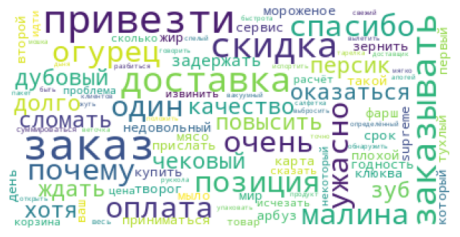

In [ ]:
# Облако слов
mpl.rcParams['font.size']=12
mpl.rcParams['savefig.dpi']=100
mpl.rcParams['figure.subplot.bottom']=.1


stopwords = set(['Здравствуйте', 'object', 'Length', 'dtype', 'столбец', 'Name', "STOPWORDS", 'None', 'index', '\n', 'отзывы', 'Без описания'])
data = end_datasets[['Отзывы клиентов']]

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=250,
                          max_font_size=40,
                          random_state=45
                         ).generate(str(data['Отзывы клиентов']))

print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("word1.png", dpi=900)



**По данному облаку слов можно сделать следующие выводы:**
1. Практически сразу бросается в глаза слово "отвратител" и также слово "ужасно", на эти отзывы стоит обратить внимание в первую очередь;
2. Множество товаров приезжают помятыми, вскрытыми, порванными, нужно обратить внимание на данные отзывы;
3. Частые претензии к мороженому, оно встречается на нашей визуализации 4 раза, если судить по моему опыту работы курьером и опыту заказов еды онлайн, скорее всего курьеры или сборщики зачастую кладут мороженое рядом с горячими блюдами или вниз пакета и при доставке мороженое мнется и тает;
4. Хоть и не явно, но на визуализации видно, что множество претензий к ожиданию заказа;
5. Можно обратить внимание на говядину, клубнику, слойку и котлеты ожадая что с ними были проблемы, но утверждать это мы не можем, поскольку в нашей визуализации хоть и много слов, но количество положительных (оценка 4-5) и отрицательных (оценка 1-3) отзывов распределено примерно 50/50, скорее всего все причины по данным товарам будут относиться к пункту 2;
6. Есть слово приложение, возможно у клиентов возникают трудности с приложением;


# Рекомендации:📢




1. Важно убрать проблемы возникающие с мороженым.
  Поскольку это морально важный продукт для покупателя, по многим причинам и он зачастую дорогой и имеет хорошую маржинальность для бизнеса, но при этом легко портится, решить проблему можно если выполнять проведение инструктажа курьерам и сборщикам, о том как нужно укладывать мороженое в термосумки и пакеты;


2. Разработка стратегии по возврату клиентов.
   В первую очередь начать обрабатывать клиентов, в отзывах которых есть слова "отвратительно", "ужасно" и "Удаляю", "Ухожу" и др. Важно это потому, что судя по колонке "Статус" обработка отзывов клиентов работает критически медленно, поскольку 448 из 57050 зявок обработано, что составляет меньше 1% от общего количества заказов и 4% от 10970 (оценки 1-3 по всем заказам);

  
3. Частые жалобы на задержку доставки, тут может быть несколько причин:
  * В сервисе необходима калибровка системы логистики курьеров - могут быть не учтены пиковые нагрузки, могут быть не учтены особенности территории и др., требуется изучать маршруты и отзывы курьеров.
  * Недостаточное количество курьеров - информации о курьерах в нашем исследовании нет;
  * Долгая сборка заказа (также может быть долгая готовка блюд, если это ресторан) - Информации о скорости сборки продуктов в нашей базе нет;

4. При таком раскладе нужно проводить полное исследование.
  
   Для полноценного исследования необходима вся информация, связанная с курьерами (сроки доставки, отзывы курьеров, количество заказов, информацию по самому курьеру и др), вся информация по продуктам (списки продуктов в каждом заказе, цены продуктов и др), вся информация по клиентам (все заказы, пол, возраст клиента и др).

5. Создать функционал в приложении для сборщиков.

  Часто не кладут определенный товар или просроченный товар в запаре, поэтому нужно сделать приложение которое будет фиксировать тот товар, который положили в корзину для доставки, сканер нужно сделать как можно удобнее и он должен быть не на телефоне а на руке, по типу польца, поскольку сканирование телефоном будет в разы медленнее чем сканер

4. Увеличить скорость проверки отзывов.
  Ранее говорил о том, что заявки обрабатываются медленно.

[Сайт референса дашборда](https://monkeylearn.com/) - отличный пример реализации дашборда по данному заданию

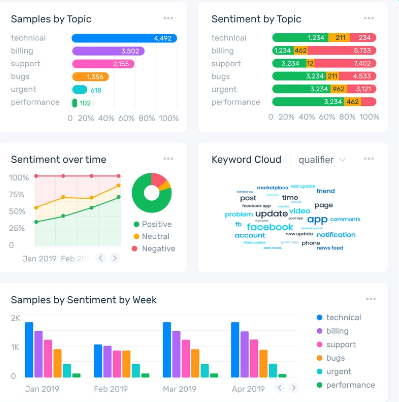